<a href="https://colab.research.google.com/github/Hafsah2020/geospatial-powerline-analysis-ng/blob/main/Geospatial_Analysis_of_Vegetation_Encroachment_Risk_for_Power_Line_Safety_in_Nigeria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geospatial Analysis of Vegetation Encroachment Risk for Power Line Safety in Nigeria

By Hafsah Anibaba

25th of December, 2024

# I. Introduction

**Project Title**: Geospatial Analysis of Vegetation Encroachment Risk for Power Line Safety in Nigeria.

**Project Goal**: Identify and prioritize high-risk locations for vegetation encroachment along power lines in Nigeria.

**Project Objectives**: To inform targeted vegetation management strategies and policies for enhanced power grid reliability.

# II. Data Acquisition and Sources


In [ ]:
# install necessary libraries

import requests
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
from google.colab import drive
drive.mount('/content/drive')
import ee
import folium
import geemap

# Initialize the Earth Engine API
ee.Authenticate()
ee.Initialize(project='gee-practice-projects24')

project_folder_path = '/content/drive/My Drive/Portfolio/month 1/my_project'

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


####  1. Power Lines Data:

**Source**: Overpass Turbo API (OpenStreetMap)

**Description**: Data on power line locations in Nigeria.

In [ ]:
# Define Overpass API URL
overpass_url = "http://overpass-api.de/api/interpreter"

# Example Overpass Turbo API query
overpass_query = """
[out:json][timeout:25];
(
  way["power"="line"](4.0, 2.0, 14.0, 14.0);  // Bounding box for Nigeria
);
out body;
>;
out skel qt;
"""


# Send the request to Overpass API
url = "http://overpass-api.de/api/interpreter"
response = requests.post(url, data={"data": overpass_query})

# Check if the response was successful
if response.status_code == 200:
    data = response.json()
    if "elements" in data and len(data["elements"]) > 0:
        print("Data retrieved successfully!")
        print(f"Number of elements: {len(data['elements'])}")
    else:
        print("Data retrieved successfully, but no elements found in the response.")
else:
    print("Failed to retrieve data:", response.status_code)

Data retrieved successfully!
Number of elements: 44755


In [ ]:
# Extract the ways that represent power lines
ways = [element for element in data['elements'] if element['type'] == 'way' and 'power' in element['tags']]

# Extract nodes (coordinates)
nodes = {node['id']: node for node in data['elements'] if node['type'] == 'node'}

# Convert the power line ways into LineString geometries
way_lines = []
for way in ways:
    coords = [(nodes[node]['lon'], nodes[node]['lat']) for node in way['nodes'] if node in nodes]
    way_lines.append(LineString(coords))

# Create a GeoDataFrame from the geometries
way_gdf = gpd.GeoDataFrame(
    way_lines,
    columns=['geometry'],
    crs="EPSG:4326"
)

way_gdf.to_file(f"{project_folder_path}/data/power_lines.geojson", driver="GeoJSON")

#### 2. Vegetation Data:
**Source**: Google Earth Engine (MODIS MOD13A1)

**Description**: NDVI data for Nigeria

In [ ]:

# Define the geometry for Nigeria
nigeria_geometry = ee.Geometry.Polygon([
    [[2.676932, 13.865924],   # Top-left corner
     [2.676932, 4.272674],    # Bottom-left corner
     [14.677982, 4.272674],   # Bottom-right corner
     [14.677982, 13.865924],  # Top-right corner
     [2.676932, 13.865924]]   # Closing the loop
])

# Load MODIS collection and filter
collection = ee.ImageCollection('MODIS/061/MOD13A1').filterDate('2023-01-01', '2024-12-31').filterBounds(nigeria_geometry)

# Create a mosaic
mosaic = collection.mosaic()

# Cast all bands to Int16
mosaic_int16 = mosaic.toInt16()

# Export the corrected mosaic
task = ee.batch.Export.image.toDrive(
    image=mosaic_int16,
     folder=f'{project_folder_path}/data',
     description='Export_Nigeria_Mosaic',
     scale=500,
     region=nigeria_geometry,
     maxPixels=1e13
)

task.start()


print("Export started. Check Google Earth Engine Task Manager.")


#### 3. Administrative Boundaries:

**Source:** Downloaded GeoJSON file (nigerian_states.geojson) from opensource map

**Description:** Boundaries of states in Nigeria.: Downloaded GeoJSON file (nigerian_states.geojson)
Description: Boundaries of states in Nigeria.

# III. Data Processing and Preparation

In [ ]:
!pip install rasterio

In [ ]:
# install necessary libraries

import geopandas as gpd
from shapely.validation import explain_validity
from google.colab import drive
drive.mount('/content/drive')
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

project_folder_path = '/content/drive/My Drive/Portfolio/month 1/my_project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####  Data Cleaning and Validation

##### **Powerlines**: Handling invalid geometries, missing values, and duplicate entries.

In [ ]:
powerline_data = gpd.read_file(f'{project_folder_path}/data/power_lines.geojson')
powerline_data.head()

,geometry
0,"LINESTRING (8.94967 13.8007, 8.94667 13.80066,..."
1,"LINESTRING (9.02468 13.59995, 9.02706 13.6133,..."
2,"LINESTRING (8.9842 13.77589, 8.98681 13.77834,..."
3,"LINESTRING (8.98237 13.75892, 8.99052 13.77237..."
4,"LINESTRING (8.98513 13.77519, 8.98789 13.77403..."


In [ ]:


# Check for missing values
print(powerline_data.isnull().sum())

# Validate geometries
invalid_geometries = powerline_data[~powerline_data.is_valid]
for geom in invalid_geometries.geometry:
    print(explain_validity(geom))

# Ensure CRS is correct (reproject if necessary)
powerline_data = powerline_data.to_crs(epsg=4326)

# Remove duplicate entries
powerline_data = powerline_data.drop_duplicates()


geometry    0
dtype: int64


##### **Administrative Boundaries**:  Ensuring consistency, CRS alignment, and renaming columns.

In [ ]:
# Load Nigeria administrative boundary data
admin_boundaries = gpd.read_file(f"{project_folder_path}/data/nigerian_states.geojson")
admin_boundaries.head(2)

,id,@id,GNS:dsg_code,GNS:dsg_string,GNS:id,ISO3166-2,admin_level,alt_name,alt_name:ar,alt_name:azb,...,source:url,state_code,surface,tourism,type,waterway,wikidata,wikipedia,@relations,geometry
0,relation/3698564,relation/3698564,None,None,None,NG-YO,4,None,None,None,...,http://ehealthafrica.org,None,None,None,boundary,None,Q682777,en:Yobe State,None,"POLYGON ((11.6622 13.30773, 11.59063 13.34631,..."
1,relation/3703236,relation/3703236,None,None,None,NG-JI,4,None,None,None,...,http://ehealthafrica.org,None,None,None,boundary,None,Q682691,en:Jigawa State,None,"POLYGON ((8.30084 12.53808, 8.30133 12.53567, ..."


In [ ]:
admin_boundaries['state']= admin_boundaries['wikipedia'].str.split(':').str[1]
admin_boundaries =admin_boundaries[['state','geometry']]

# Check for consistency (e.g., no missing or duplicate states)
print(admin_boundaries["state"].value_counts())

# Ensure CRS alignment with other datasets
admin_boundaries = admin_boundaries.to_crs(epsg=4326)


state
Federal Capital Territory, Nigeria    2
Yobe State                            1
Lokoja                                1
Uyo                                   1
Lafia                                 1
                                     ..
Niger State                           1
Lagos State                           1
Kwara State                           1
Kogi State                            1
Umuahia                               1
Name: count, Length: 73, dtype: int64


In [ ]:
(admin_boundaries["state"].value_counts()>1).sum()

1

In [ ]:
admin_boundaries["state"].unique()

array(['Yobe State', 'Jigawa State', 'Zamfara State', 'Sokoto State',
       'Kebbi State', 'Kaduna State', 'Kano State', 'Katsina State',
       'Abia State', 'Akwa Ibom State', 'Anambra State', 'Bayelsa State',
       'Benue State', 'Cross River State', 'Delta State', 'Ebonyi State',
       'Edo State', 'Ekiti State', 'Enugu State',
       'Federal Capital Territory, Nigeria', 'Imo State', 'Kogi State',
       'Kwara State', 'Lagos State', 'Niger State', 'Ogun State',
       'Ondo State', 'Osun State', 'Adamawa State', 'Gombe State',
       'Nasarawa State', 'Oyo State', 'Plateau State', 'Rivers State',
       'Taraba State', 'Borno State', 'Bauchi State', None,
       'Port Harcourt', 'Ibadan', 'Ilorin', 'Kaduna', 'Enugu', 'Abeokuta',
       'Maiduguri', 'Lagos', 'Abuja', 'Yenagoa', 'Calabar', 'Bauchi',
       'Jalingo', 'Makurdi', 'Lafia', 'Uyo', 'Lokoja', 'Kano (city)',
       'Damaturu', 'Osogbo', 'Katsina', 'Gusau', 'Yola, Adamawa', 'Jos',
       'Abakaliki', 'Sokoto', 'Dutse', 

In [ ]:
admin_boundaries = admin_boundaries.rename(columns={'state': 'City'})

In [ ]:
admin_boundaries.to_file(f"{project_folder_path}/data/processed_data/admin_boundaries.geojson", driver="GeoJSON")

##### **Vegetation:** Clipping to Nigeria's boundaries, handling missing data, and converting to a suitable format.

In [ ]:
# Load raster data
vegetation_data = rasterio.open(f"{project_folder_path}/data/Export_Nigeria_Mosaic.tif")
vegetation_data

<open DatasetReader name='/content/drive/My Drive/Portfolio/month 1/my_project/data/Export_Nigeria_Mosaic.tif' mode='r'>

In [ ]:
# Load Nigeria shapefile for clipping
nigeria_shapefile = gpd.read_file(f"{project_folder_path}/data/nigerian_states.geojson")

# Clip the raster to Nigeria's boundaries
vegetation_clipped, transform = mask(vegetation_data, nigeria_shapefile.geometry, crop=True)

# Check for missing data and handle NaN values (if any)
vegetation_clipped = np.nan_to_num(vegetation_clipped, nan=-9999)  # Replace NaN with -9999 (or another value)


In [ ]:
def reproject_raster(input_raster_path, output_raster_path, target_crs="EPSG:3857"):
    with rasterio.open(input_raster_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_raster_path, 'w', **kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest) # or another resampling method

# Example usage (replace with your file paths)
input_raster = f"{project_folder_path}/data/Export_Nigeria_Mosaic.tif"
output_raster = f"{project_folder_path}/data/Export_Nigeria_Mosaic_3857.tif"

reproject_raster(input_raster, output_raster)



#### Data Transformation

* Reprojecting vegetation data to EPSG:3857.
* Extracting NDVI values for power line locations.
* Handling out-of-bounds coordinates.
* Creating GeoDataFrames.

extract_ndvi is a function to associate NDVI values with powerlines based on their centroid locations. Will extract NDVI value for a given point, to handle out-of-bounds errors and also give information on powerline coordinates that are out of bound.

returns the ndvi value for the centeroid of each powerline

In [ ]:
def extract_ndvi(point_geometry, raster, transform):
    """Extract NDVI value for a given point, handling out-of-bounds errors."""
    row, col = ~transform * (point_geometry.x, point_geometry.y)
    row, col = int(row), int(col)
    try:
        return raster.read(1)[row, col]
    except IndexError:
        return np.nan

# Now use output_raster in your code instead of vegetation_data
vegetation_data_3857 = rasterio.open(output_raster)

# Ensure powerlines are points or centroids
powerline_temp = powerline_data.copy()
powerline_temp = powerline_temp.to_crs("EPSG:3857")
powerline_centroids = powerline_temp.geometry.centroid

# Extract NDVI values, handling out-of-bounds errors
powerline_data["ndvi"] = powerline_centroids.apply(
    lambda point: extract_ndvi(point, vegetation_data_3857, vegetation_data_3857.transform)
)

# Separate out-of-bounds rows
out_of_bounds_powerlines = powerline_data[powerline_data['ndvi'].isnull()]
in_bounds_powerlines = powerline_data.dropna(subset=['ndvi'])

# Create a GeoDataFrame for the in-bounds powerlines with NDVI and geometry
in_bounds_gdf = gpd.GeoDataFrame(in_bounds_powerlines[['ndvi', 'geometry']], geometry='geometry', crs=powerline_data.crs)

# Print the number of out-of-bounds coordinates
print(f'{len(out_of_bounds_powerlines)} powerline coordinates were out of bounds out of a total of {len(powerline_data)} powerlines')

# Now you have two GeoDataFrames:
# - in_bounds_gdf: Contains NDVI and geometry for points within the raster bounds.
# - out_of_bounds_powerlines: Contains the original rows that were out of bounds.

in_bounds_gdf.head()

13 powerline coordinates were out of bounds out of a total of 771 powerlines


,ndvi,geometry
0,5429.0,"LINESTRING (8.94967 13.8007, 8.94667 13.80066,..."
1,6692.0,"LINESTRING (9.02468 13.59995, 9.02706 13.6133,..."
2,7431.0,"LINESTRING (8.9842 13.77589, 8.98681 13.77834,..."
3,6911.0,"LINESTRING (8.98237 13.75892, 8.99052 13.77237..."
4,6988.0,"LINESTRING (8.98513 13.77519, 8.98789 13.77403..."


Needed to convert to 3857 crs because centroid gave warning of possible inacurate values when done on projection 4326

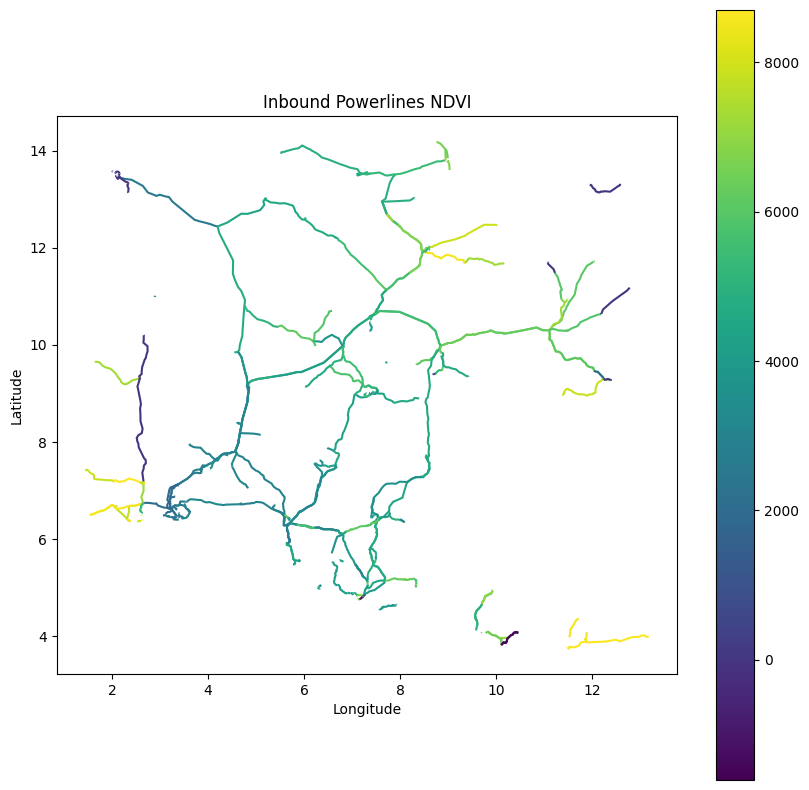

In [ ]:
# Assuming in_bounds_gdf is your GeoDataFrame with 'geometry' and 'ndvi' columns
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Plot the inbound powerlines
in_bounds_gdf.plot(ax=ax, column='ndvi', legend=True, cmap='viridis') # Change cmap to other colormap

# Customize the plot (optional)
ax.set_title("Inbound Powerlines NDVI")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [ ]:
print(in_bounds_gdf.crs)
print(admin_boundaries.crs)

EPSG:4326
EPSG:4326


In [ ]:
# Cuts out" the powerlines that fall outside the boundaries of the focus areas (Nigeria)
clipped_powerlines = gpd.clip(in_bounds_gdf, admin_boundaries)
#includes the name of the city to the dataframe
powerlines_with_city = gpd.sjoin(clipped_powerlines, admin_boundaries[['City', 'geometry']], how='inner', predicate='intersects')
powerlines_with_city

,ndvi,geometry,index_right,City
624,5794.0,"LINESTRING (7.15735 4.76307, 7.15687 4.76266)",33,Rivers State
625,5794.0,"LINESTRING (7.15735 4.76307, 7.15656 4.76279)",33,Rivers State
278,6742.0,"LINESTRING (7.08285 4.84569, 7.08354 4.84584, ...",33,Rivers State
277,5589.0,"LINESTRING (7.10576 4.85264, 7.1071 4.84999, 7...",33,Rivers State
279,5659.0,"LINESTRING (7.09992 4.85759, 7.10198 4.85586, ...",33,Rivers State
...,...,...,...,...
302,6915.0,"LINESTRING (8.58752 12.02294, 8.58851 12.0225)",6,Kano State
303,6939.0,"LINESTRING (8.58839 12.02299, 8.58764 12.02305...",6,Kano State
304,6939.0,"LINESTRING (8.58843 12.02314, 8.58775 12.02316...",6,Kano State
312,4891.0,"LINESTRING (8.30024 13.02618, 8.29991 13.02643...",7,Katsina State


Takes multiple ndvi values across the powerlines and returns the average for each powerline

In [ ]:
# Define a function to extract NDVI values
def extract_ndvi_for_geometry(geometry, raster, transform):
    # Mask raster with the geometry
    masked, masked_transform = rasterio.mask.mask(raster, [geometry], crop=True)
    ndvi_values = masked[0]  # NDVI values in the clipped region
    return np.nanmean(ndvi_values)  # Return mean NDVI as an example

# Apply to all powerline geometries
powerlines_with_city['ndvi'] = powerlines_with_city.geometry.apply(
    lambda geom: extract_ndvi_for_geometry(geom, vegetation_data, vegetation_data.transform)
)

powerlines_with_city

,ndvi,geometry,index_right,City
624,5799.000000,"LINESTRING (7.15735 4.76307, 7.15687 4.76266)",33,Rivers State
625,5799.000000,"LINESTRING (7.15735 4.76307, 7.15656 4.76279)",33,Rivers State
278,631.304408,"LINESTRING (7.08285 4.84569, 7.08354 4.84584, ...",33,Rivers State
277,2048.777778,"LINESTRING (7.10576 4.85264, 7.1071 4.84999, 7...",33,Rivers State
279,3361.333333,"LINESTRING (7.09992 4.85759, 7.10198 4.85586, ...",33,Rivers State
...,...,...,...,...
302,2368.000000,"LINESTRING (8.58752 12.02294, 8.58851 12.0225)",6,Kano State
303,2368.000000,"LINESTRING (8.58839 12.02299, 8.58764 12.02305...",6,Kano State
304,2368.000000,"LINESTRING (8.58843 12.02314, 8.58775 12.02316...",6,Kano State
312,159.338816,"LINESTRING (8.30024 13.02618, 8.29991 13.02643...",7,Katsina State


In [ ]:
powerlines_with_city = powerlines_with_city.drop(columns=['index_right'])
powerlines_with_city = powerlines_with_city[['City', 'ndvi', 'geometry']]
powerlines_with_city = powerlines_with_city.reset_index(drop=True)

The final geodataframe is data on average across ndvi values along the powerlines in bound

#### Data Wrangling and Cleaning of Transformed data

In [ ]:
powerlines_with_city.describe()

,ndvi
count,772.000000
mean,2047.146747
std,1904.749006
min,8.500000
25%,218.344499
50%,1754.500000
75%,3289.000000
max,7544.000000


###### Missing Data

In [ ]:
powerlines_with_city.isna().sum()

,0
City,4
ndvi,0
geometry,0


In [ ]:
print(powerlines_with_city[powerlines_with_city['City'].isna()]['geometry'].to_list())
print(powerlines_with_city[powerlines_with_city['City'].isna()].index.to_list())

[<LINESTRING (8.062 5.181, 8.065 5.18, 8.072 5.178, 8.075 5.177, 8.078 5.177,...>, <LINESTRING (7.681 5.152, 7.682 5.152, 7.686 5.152, 7.69 5.152, 7.695 5.152,...>, <LINESTRING (3.246 6.603, 3.245 6.603, 3.242 6.606, 3.238 6.61, 3.234 6.614,...>, <LINESTRING (3.716 12.576, 3.717 12.575, 3.721 12.574, 3.724 12.573, 3.726 1...>]
[231, 234, 425, 666]


In [ ]:
from geopy.geocoders import Nominatim

# Initialize geolocator
geolocator = Nominatim(user_agent="geoapi")

locations = [(8.062, 5.181),
             (7.681, 5.152),
             (3.246, 6.603),
             (3.716, 12.576)]

# Reverse geocode the coordinates
for location_ in locations:
    location = geolocator.reverse(location_)
    try:
        print(location.address)
    except:
        print("No address found")

In [ ]:
powerlines_with_city.loc[231, 'City'] = 'Kwara'
powerlines_with_city.loc[234, 'City'] = 'Ekiti'
powerlines_with_city = powerlines_with_city.drop(index=[425, 666])
powerlines_with_city.isna().sum()


,0
City,0
ndvi,0
geometry,0


In [ ]:
# prompt: can I us geoloacator to create a column in powerlines_with_city to pick the first coordinate in each row geometry and return the city name
# Initialize geolocator
geolocator = Nominatim(user_agent="geoapi")

def get_city_from_coords(geometry):
    try:
        # Extract coordinates from the geometry
        longitude, latitude = geometry.coords[0]
        location = geolocator.reverse((latitude, longitude)) #Note the order (lat, lon)
        if location and 'address' in location.raw:
          address = location.raw['address']
          if 'city' in address:
              return address['city']
          elif 'town' in address:
            return address['town']
          elif 'village' in address:
            return address['village']
          else:
              return None # or some default value
        else:
          return None
    except Exception as e:
        print(f"Error geocoding coordinates: {e}")
        return None

# Apply the function to create the new 'geolocated_city' column
powerlines_with_city['geolocated_city'] = powerlines_with_city['geometry'].apply(get_city_from_coords)



In [ ]:
# Display the updated GeoDataFrame
powerlines_with_city.head()

,City,ndvi,geometry,geolocated_city
0,Rivers State,5799.000000,"LINESTRING (7.15735 4.76307, 7.15687 4.76266)",Ogani
1,Rivers State,5799.000000,"LINESTRING (7.15735 4.76307, 7.15656 4.76279)",Ogani
2,Rivers State,631.304408,"LINESTRING (7.08285 4.84569, 7.08354 4.84584, ...",Elelenwo
3,Rivers State,2048.777778,"LINESTRING (7.10576 4.85264, 7.1071 4.84999, 7...",None
4,Rivers State,3361.333333,"LINESTRING (7.09992 4.85759, 7.10198 4.85586, ...",Elelenwo


In [ ]:
powerlines_with_city.isna().sum()

,0
City,0
ndvi,0
geometry,0
geolocated_city,237


###### Duplicates

There is a duplicate , I wanto check the duplicates in the data

In [ ]:
powerlines_with_city[powerlines_with_city['geometry'].duplicated()]

,City,ndvi,geometry,geolocated_city
17,Abia State,350.719565,"LINESTRING (7.32106 5.05543, 7.32155 5.05205, ...",Aba
19,Rivers State,134.289553,"LINESTRING (7.25386 4.85059, 7.26243 4.85255, ...",Oyigbo
20,Abia State,134.289553,"LINESTRING (7.25386 4.85059, 7.26243 4.85255, ...",Oyigbo
42,Abia State,172.960082,"LINESTRING (7.06947 5.46819, 7.07164 5.46626, ...",Naze
43,Imo State,172.960082,"LINESTRING (7.06947 5.46819, 7.07164 5.46626, ...",Naze
...,...,...,...,...
748,Katsina State,21.640886,"LINESTRING (8.4764 11.92948, 8.47671 11.92982,...",Garun Gawa
755,Yobe State,113.025253,"LINESTRING (11.35805 10.94686, 11.35704 10.953...",None
758,Jigawa State,135.582696,"LINESTRING (9.34871 11.68993, 9.34896 11.69015...",Dutse
760,Jigawa State,72.456980,"LINESTRING (8.47677 11.92906, 8.4772 11.92932,...",Garun Gawa


There are 109 duplicates, but the first 2 rows that gave hint on duplicates is not captured there's something about the geometry value, I will use another column

In [ ]:
powerlines_with_city[powerlines_with_city['ndvi'].duplicated()]

,City,ndvi,geometry,geolocated_city
1,Rivers State,5799.000000,"LINESTRING (7.15735 4.76307, 7.15656 4.76279)",Ogani
17,Abia State,350.719565,"LINESTRING (7.32106 5.05543, 7.32155 5.05205, ...",Aba
19,Rivers State,134.289553,"LINESTRING (7.25386 4.85059, 7.26243 4.85255, ...",Oyigbo
20,Abia State,134.289553,"LINESTRING (7.25386 4.85059, 7.26243 4.85255, ...",Oyigbo
31,Delta State,5158.000000,"LINESTRING (5.9131 5.54194, 5.91375 5.54155)",None
...,...,...,...,...
758,Jigawa State,135.582696,"LINESTRING (9.34871 11.68993, 9.34896 11.69015...",Dutse
760,Jigawa State,72.456980,"LINESTRING (8.47677 11.92906, 8.4772 11.92932,...",Garun Gawa
765,Jigawa State,35.026862,"LINESTRING (8.61448 12.01034, 8.6181 12.01082,...",Babawa
768,Kano State,2368.000000,"LINESTRING (8.58839 12.02299, 8.58764 12.02305...",Kawaji


In [ ]:
powerlines_with_city[powerlines_with_city['geolocated_city'].duplicated()]

,City,ndvi,geometry,geolocated_city
1,Rivers State,5799.000000,"LINESTRING (7.15735 4.76307, 7.15656 4.76279)",Ogani
4,Rivers State,3361.333333,"LINESTRING (7.09992 4.85759, 7.10198 4.85586, ...",Elelenwo
7,Rivers State,629.573964,"LINESTRING (7.09992 4.85759, 7.09007 4.86493, ...",Elelenwo
8,Rivers State,3567.000000,"LINESTRING (6.97634 4.8926, 6.97903 4.89246)",None
9,Rivers State,3802.500000,"LINESTRING (6.96383 4.89439, 6.96543 4.89317, ...",None
...,...,...,...,...
766,Kano State,1838.000000,"LINESTRING (8.55706 11.99594, 8.55605 11.99593...",Giginyu
767,Kano State,2368.000000,"LINESTRING (8.58752 12.02294, 8.58851 12.0225)",Kawaji
768,Kano State,2368.000000,"LINESTRING (8.58839 12.02299, 8.58764 12.02305...",Kawaji
769,Kano State,2368.000000,"LINESTRING (8.58843 12.02314, 8.58775 12.02316...",Kawaji


spotted the difference between the geometry of the first 2 rows that gave hints of duplicates data

the similarity in ndvi, city could be they start from the source but along the route they're diverted to different location thus the swith in the 3rd coordinates

I will use the geometry column to judge duplicates

I want see compare the number of duplicates to the total number

In [ ]:
ratio = powerlines_with_city['geometry'].duplicated().sum() / powerlines_with_city.shape[0]
print(f'we have {round(ratio * 100, 2)} percent of repetition in the data')

we have 14.16 percent of repetition in the data


That is a large fraction, but I have to drop them

In [ ]:
# prompt: powerlines_with_city.drop([powerlines_with_city['geometry'].duplicated()])

powerlines_with_city = powerlines_with_city.drop_duplicates(subset='geometry')

In [ ]:
powerlines_with_city.duplicated().sum()

0

###### Accuracy

**NDVI range scaling**

data ranges from 8.5 to 7544

The MODIS MOD13A1 dataset from Google Earth Engine provides vegetation indices, including NDVI, at a spatial resolution of 500 meters. In this dataset:

NDVI Values are stored as scaled integers ypically ranging from -10,000 to 10,000. To convert them to the proper range [−1,1], you need to divide by 10,000.
The scale factor for NDVI in MOD13A1 is 0.0001.

In [ ]:
powerlines_with_city.loc[:, 'ndvi'] = powerlines_with_city['ndvi'] / 10000
powerlines_with_city.describe()

,ndvi
count,661.000000
mean,0.235677
std,0.188585
min,0.000850
25%,0.049225
50%,0.232400
75%,0.368200
max,0.754400


In [ ]:
powerlines_with_city.total_bounds

array([ 2.79075059,  4.5596957 , 12.7828475 , 13.32336279])

In [ ]:
print(f'{powerlines_with_city.is_valid.sum()} valid geometries out of {powerlines_with_city.shape[0]} observations')  # Check for ratio of invalid geometries
# gdf = gdf[gdf.is_valid]  # Remove invalid geometries


661 valid geometries out of 661 observations


In [ ]:
print(powerlines_with_city.dtypes)

City                 object
ndvi                float64
geometry           geometry
geolocated_city      object
dtype: object


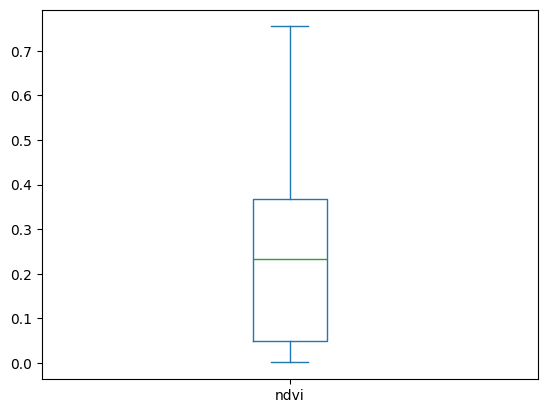

In [ ]:
powerlines_with_city['ndvi'].plot.box();  # Visualize NDVI outliers


In [ ]:
# Completeness
assert not powerlines_with_city.drop(columns=['geolocated_city']).isnull().any().any(), "Missing values detected!"

# Validity
assert powerlines_with_city.is_valid.all(), "Invalid geometries found!"

# CRS
assert powerlines_with_city.crs == "EPSG:4326", "Incorrect CRS!"

# Attribute Checks
assert powerlines_with_city['ndvi'].between(-1, 1).all(), "NDVI values out of range!"


##### Visualisation

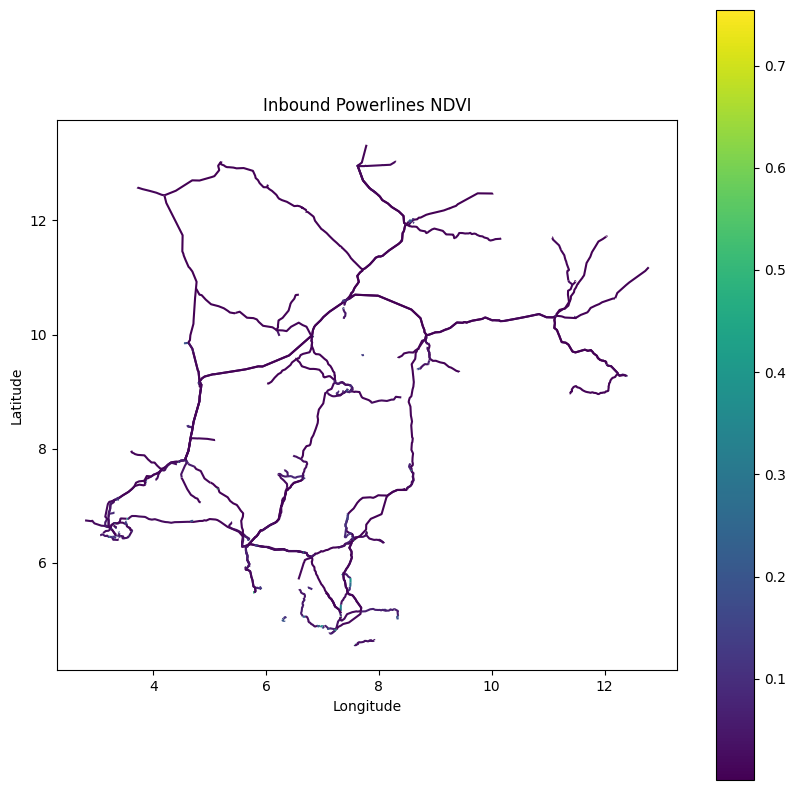

In [ ]:
# prompt: I want to plot inbound gdf geospatially

import matplotlib.pyplot as plt

# Assuming in_bounds_gdf is your GeoDataFrame with 'geometry' and 'ndvi' columns
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Plot the inbound powerlines
powerlines_with_city.plot(ax=ax, column='ndvi', legend=True, cmap='viridis') # Change cmap to other colormap

# Customize the plot (optional)
ax.set_title("Inbound Powerlines NDVI")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [ ]:
powerlines_with_city.to_file(f"{project_folder_path}/data/processed_data/powerlines_with_city.geojson", driver="GeoJSON")

# IV. Data Analysis and Interpretation


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

# Initialize the geolocator
geolocator = Nominatim(user_agent="my_geocoder")

project_folder_path = '/content/drive/My Drive/Portfolio/month 1/my_project'

Mounted at /content/drive


Reading processed data and processed boundaries data

In [2]:
data = gpd.read_file(f"{project_folder_path}/data/processed_data/powerlines_with_city.geojson")
admin_boundaries = gpd.read_file(f"{project_folder_path}/data/processed_data/admin_boundaries.geojson")
data.head()

,City,ndvi,geolocated_city,geometry
0,Rivers State,0.579900,Ogani,"LINESTRING (7.15735 4.76307, 7.15687 4.76266)"
1,Rivers State,0.579900,Ogani,"LINESTRING (7.15735 4.76307, 7.15656 4.76279)"
2,Rivers State,0.063130,Elelenwo,"LINESTRING (7.08285 4.84569, 7.08354 4.84584, ..."
3,Rivers State,0.204878,None,"LINESTRING (7.10576 4.85264, 7.1071 4.84999, 7..."
4,Rivers State,0.336133,Elelenwo,"LINESTRING (7.09992 4.85759, 7.10198 4.85586, ..."


###### Descriptive Analysis:

*   **Exploring NDVI distribution using histograms and boxplots.**



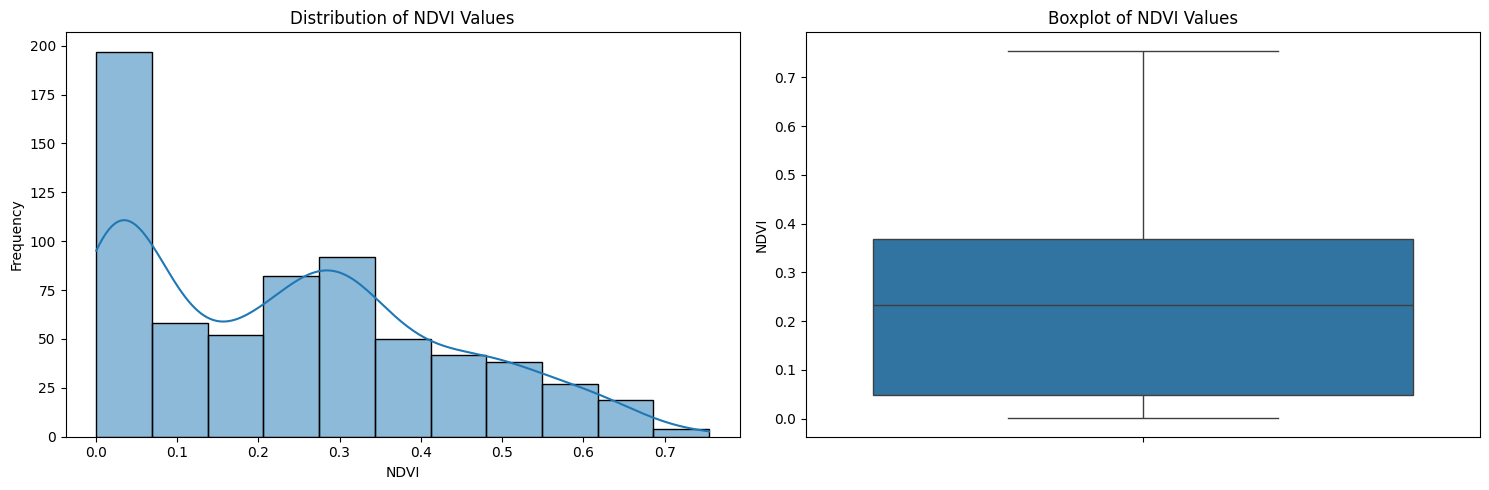

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # create a figure with two subplots

sns.histplot(data['ndvi'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of NDVI Values')
axes[0].set_xlabel('NDVI')
axes[0].set_ylabel('Frequency')

sns.boxplot(y='ndvi', data=data, ax=axes[1])
axes[1].set_title('Boxplot of NDVI Values')
axes[1].set_ylabel('NDVI')

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

*   **Identifying the frequency of power lines in each city according to data.**

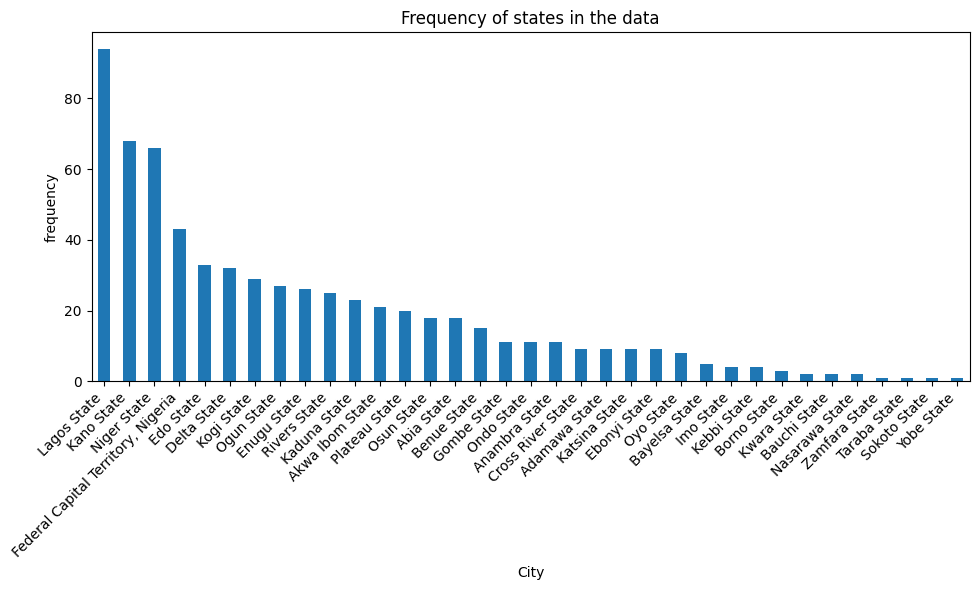

In [4]:
city_counts = data['City'].value_counts()

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
city_counts.plot(kind='bar')
plt.title('Frequency of states in the data')
plt.xlabel('City')
plt.ylabel('frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

*   **Variation in average ndvi values along powerlines according to state**

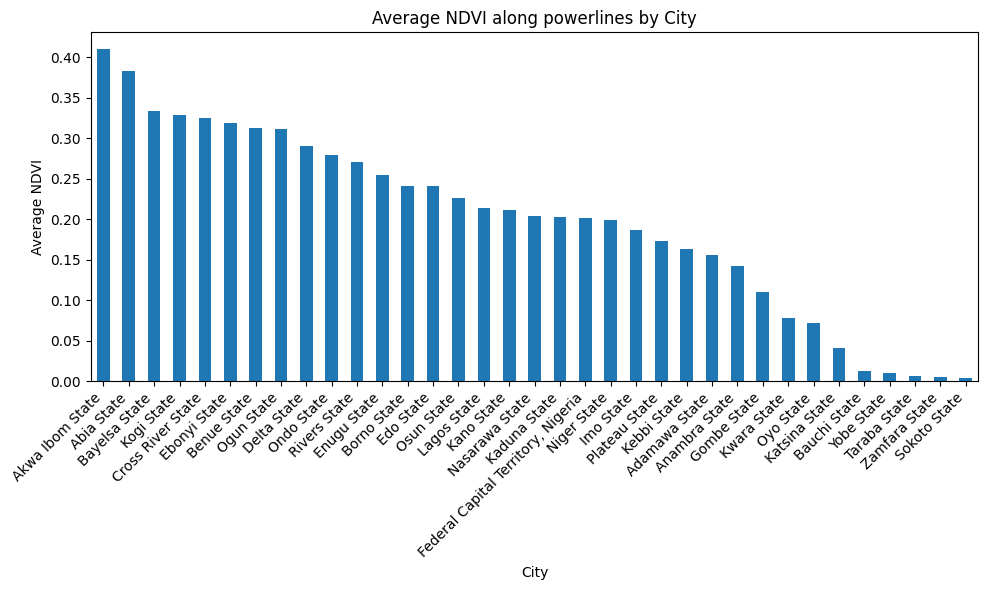

In [5]:
#Which cities have the highest or lowest average NDVI values?

ndvi_by_city = data.groupby('City')['ndvi'].mean().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
ndvi_by_city.plot(kind='bar')
plt.title('Average NDVI along powerlines by City')
plt.xlabel('City')
plt.ylabel('Average NDVI')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

###### Spatial Analysis

* **Choropleth map of average ndvi values across Nigeria**




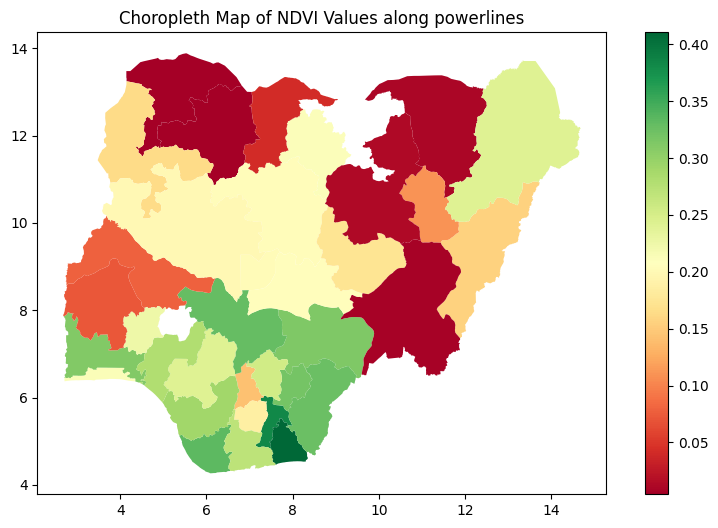

In [6]:
average_ndvi = data.groupby('City')['ndvi'].mean()
map_data = admin_boundaries.merge(average_ndvi, left_on='City', right_index=True, how='left')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
map_data.plot(column='ndvi', cmap='RdYlGn', legend=True, ax=ax)
plt.title("Choropleth Map of NDVI Values along powerlines")
plt.show()


Ekiti and Jigawa

In [7]:
admin_boundaries['City'].unique()

array(['Yobe State', 'Jigawa State', 'Zamfara State', 'Sokoto State',
       'Kebbi State', 'Kaduna State', 'Kano State', 'Katsina State',
       'Abia State', 'Akwa Ibom State', 'Anambra State', 'Bayelsa State',
       'Benue State', 'Cross River State', 'Delta State', 'Ebonyi State',
       'Edo State', 'Ekiti State', 'Enugu State',
       'Federal Capital Territory, Nigeria', 'Imo State', 'Kogi State',
       'Kwara State', 'Lagos State', 'Niger State', 'Ogun State',
       'Ondo State', 'Osun State', 'Adamawa State', 'Gombe State',
       'Nasarawa State', 'Oyo State', 'Plateau State', 'Rivers State',
       'Taraba State', 'Borno State', 'Bauchi State', None,
       'Port Harcourt', 'Ibadan', 'Ilorin', 'Kaduna', 'Enugu', 'Abeokuta',
       'Maiduguri', 'Lagos', 'Abuja', 'Yenagoa', 'Calabar', 'Bauchi',
       'Jalingo', 'Makurdi', 'Lafia', 'Uyo', 'Lokoja', 'Kano (city)',
       'Damaturu', 'Osogbo', 'Katsina', 'Gusau', 'Yola, Adamawa', 'Jos',
       'Abakaliki', 'Sokoto', 'Dutse', 

###### Relationship Analysis:

* **Investigating the relationship between NDVI and power line density.**

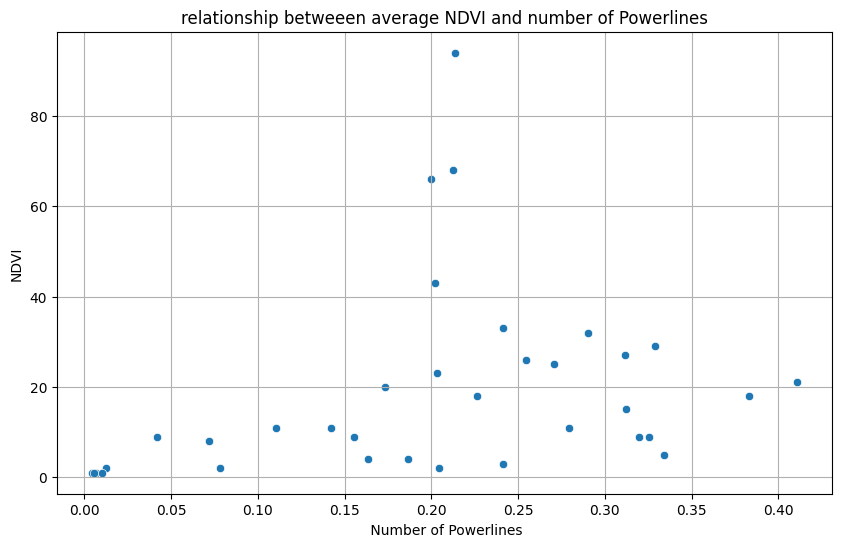

In [8]:
number_of_powerline = data.groupby('City').size().rename('number of powerlines')
average_ndvi = data.groupby('City')['ndvi'].mean().rename('average NDVI')

# Assuming number_of_powerline and average_ndvi are pandas Series
merged_data = pd.merge(number_of_powerline, average_ndvi, left_index=True, right_index=True)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.scatterplot(x=merged_data['average NDVI'], y=merged_data['number of powerlines'])

plt.title('relationship betweeen average NDVI and number of Powerlines')
plt.xlabel(' Number of Powerlines')
plt.ylabel('NDVI')
plt.grid(True)
plt.show()

* **Identifying frequency of hotspots in different states**

['Abia State', 'Akwa Ibom State', 'Bayelsa State', 'Benue State', 'Cross River State', 'Delta State', 'Ebonyi State', 'Edo State', 'Enugu State', 'Kaduna State', 'Kebbi State', 'Kogi State', 'Lagos State', 'Niger State', 'Ogun State', 'Ondo State', 'Osun State', 'Plateau State', 'Rivers State']


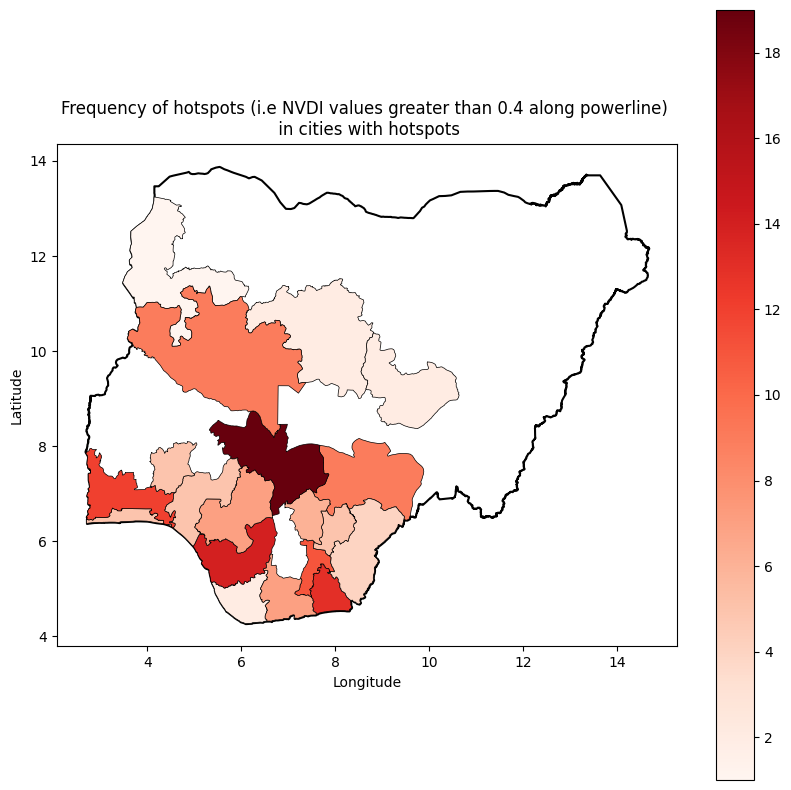

In [9]:
#hotspots are powerlines associated with ndvi above 0.4

hotspots_count_per_state = data[data['ndvi'] > 0.4].groupby('City')['ndvi'].count().reset_index(name='number of hotspots')

print(hotspots_count_per_state['City'].to_list())

# Merge hotspot data with admin boundaries
merged_data = admin_boundaries.merge(hotspots_count_per_state, left_on='City', right_on='City', how='left')
merged_data = merged_data[merged_data['number of hotspots'].notna()]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Create a GeoDataFrame with only the outer boundary of Nigeria
nigeria_boundary = admin_boundaries.dissolve()  # Dissolve internal boundaries

# Plot the outer boundary
nigeria_boundary.plot(ax=ax, color='white', edgecolor='black', linewidth=1.5)

# Plot the Nigerian states as a choropleth with color based on hotspots
# Use the 'column' argument to specify the data for coloring
merged_data.plot(ax=ax, column='number of hotspots', cmap='Reds', legend=True,  # Use a suitable colormap
                 edgecolor='black', linewidth=0.5)  # Customize border appearance

# Customize the plot
ax.set_title('Frequency of hotspots (i.e NVDI values greater than 0.4 along powerline) \n in cities with hotspots')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

* **Relationship between Average NDVI, Number of Hotspots and number of powerlines**

In [10]:
merged_data = pd.merge(average_ndvi, hotspots_count_per_state, left_index=True, right_on='City')
merged_data = pd.merge(number_of_powerline, merged_data, left_index=True, right_on= 'City')
merged_data

,number of powerlines,average NDVI,City,number of hotspots
0,18,0.382868,Abia State,11
1,21,0.410508,Akwa Ibom State,13
2,5,0.333978,Bayelsa State,2
3,15,0.312403,Benue State,9
4,9,0.325113,Cross River State,4
5,32,0.290521,Delta State,14
6,9,0.319587,Ebonyi State,5
7,33,0.241050,Edo State,7
8,26,0.254416,Enugu State,6
9,23,0.203413,Kaduna State,2


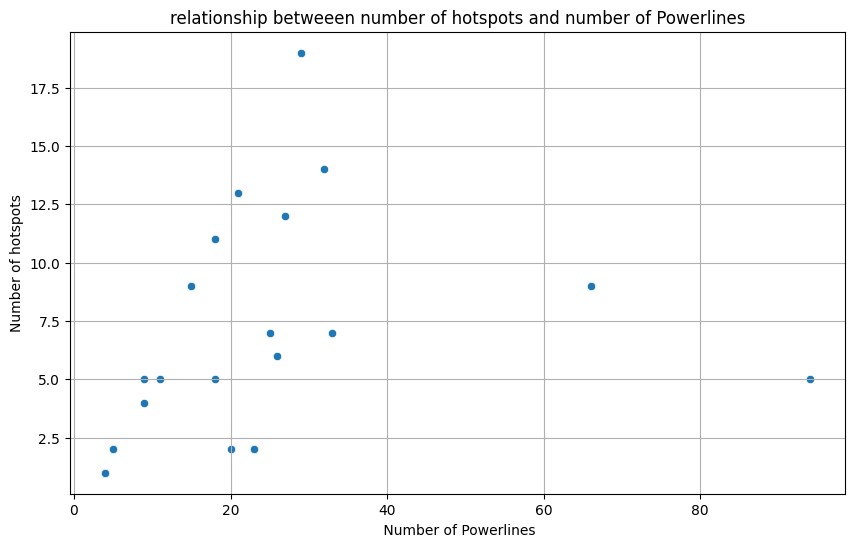

In [11]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.scatterplot(x=merged_data['number of powerlines'], y=merged_data['number of hotspots'])

plt.title('relationship betweeen number of hotspots and number of Powerlines')
plt.xlabel(' Number of Powerlines')
plt.ylabel('Number of hotspots')
plt.grid(True)
plt.show()

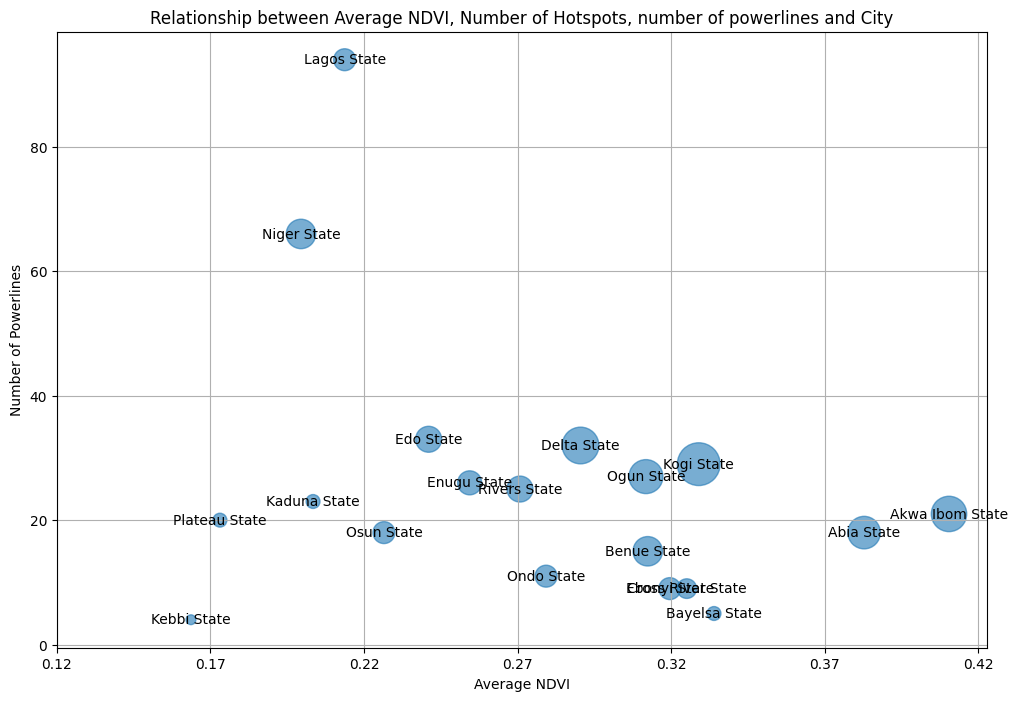

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot with bubble size representing the number of hotspots
merged_data.plot.scatter(x='average NDVI', y='number of powerlines', s=merged_data['number of hotspots'] * 50,  # Adjust the scaling factor (50) as needed
                         alpha=0.6, ax=ax)

# Add city labels to the bubbles
for i, row in merged_data.iterrows():
    ax.text(row['average NDVI'], row['number of powerlines'], row['City'], ha='center', va='center')

# Customize plot
plt.title('Relationship between Average NDVI, Number of Hotspots, number of powerlines and City')
plt.xlabel('Average NDVI')
plt.ylabel('Number of Powerlines')
plt.grid(True)
plt.xticks(np.arange(0.12, 0.47, 0.05))  # Set x-axis ticks at intervals of 2

# Show plot
plt.show()



In [13]:

# List of states from merged_data
states = merged_data['City'].tolist()

# Create an empty list to store the geometries
geometries = []

# Iterate through the states and retrieve their geometries
for state in states:
    # Find the corresponding geometry in admin_boundaries
    state_geometry = admin_boundaries[admin_boundaries['City'] == state]['geometry'].iloc[0]
    geometries.append(state_geometry)

# Create a GeoDataFrame from the geometries and states
state_geometries = gpd.GeoDataFrame({'City': states, 'geometry': geometries})

# Print the resulting GeoDataFrame
state_geometries

,City,geometry
0,Abia State,"POLYGON ((7.91486 5.52087, 7.90794 5.53578, 7...."
1,Akwa Ibom State,"POLYGON ((7.50158 4.80831, 7.50774 4.80396, 7...."
2,Bayelsa State,"POLYGON ((6.48924 5.37966, 6.49147 5.37694, 6...."
3,Benue State,"POLYGON ((9.46737 6.45583, 9.47192 6.45417, 9...."
4,Cross River State,"POLYGON ((8.99202 6.69236, 8.98973 6.69238, 8...."
5,Delta State,"POLYGON ((6.63395 5.73029, 6.64363 5.74733, 6...."
6,Ebonyi State,"POLYGON ((7.66832 6.06062, 7.66398 6.04906, 7...."
7,Edo State,"POLYGON ((6.66892 6.50123, 6.6647 6.53236, 6.6..."
8,Enugu State,"POLYGON ((7.70392 6.60706, 7.70167 6.61077, 7...."
9,Kaduna State,"POLYGON ((6.13671 10.66865, 6.13667 10.66855, ..."


In [14]:

# Assuming 'number_of_powerline' and 'average_ndvi' are already defined as in the original code


# List of states from merged_data
states = merged_data['City'].tolist()

# Create an empty list to store the geometries
geometries = []

# Iterate through the states and retrieve their geometries
for state in states:
    # Find the corresponding geometry in admin_boundaries
    state_geometry = admin_boundaries[admin_boundaries['City'] == state]['geometry'].iloc[0]
    geometries.append(state_geometry)

# Create a GeoDataFrame from the geometries and states
state_geometries = gpd.GeoDataFrame({'City': states, 'geometry': geometries})

# Merge geometries with other data
merged_data = pd.merge(merged_data, state_geometries, on='City', how='left')
merged_data = gpd.GeoDataFrame(merged_data, geometry='geometry')
# Now merged_data contains the geometries as well as the other columns
merged_data

,number of powerlines,average NDVI,City,number of hotspots,geometry
0,18,0.382868,Abia State,11,"POLYGON ((7.91486 5.52087, 7.90794 5.53578, 7...."
1,21,0.410508,Akwa Ibom State,13,"POLYGON ((7.50158 4.80831, 7.50774 4.80396, 7...."
2,5,0.333978,Bayelsa State,2,"POLYGON ((6.48924 5.37966, 6.49147 5.37694, 6...."
3,15,0.312403,Benue State,9,"POLYGON ((9.46737 6.45583, 9.47192 6.45417, 9...."
4,9,0.325113,Cross River State,4,"POLYGON ((8.99202 6.69236, 8.98973 6.69238, 8...."
5,32,0.290521,Delta State,14,"POLYGON ((6.63395 5.73029, 6.64363 5.74733, 6...."
6,9,0.319587,Ebonyi State,5,"POLYGON ((7.66832 6.06062, 7.66398 6.04906, 7...."
7,33,0.241050,Edo State,7,"POLYGON ((6.66892 6.50123, 6.6647 6.53236, 6.6..."
8,26,0.254416,Enugu State,6,"POLYGON ((7.70392 6.60706, 7.70167 6.61077, 7...."
9,23,0.203413,Kaduna State,2,"POLYGON ((6.13671 10.66865, 6.13667 10.66855, ..."


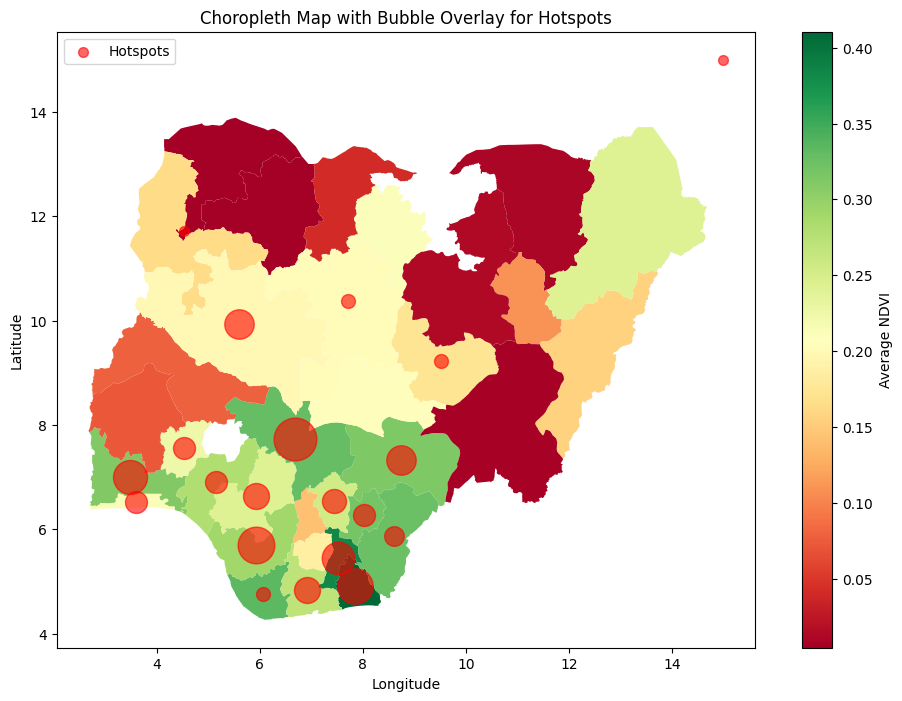

In [15]:
import matplotlib.pyplot as plt

# Assuming 'merged_data' is your DataFrame with 'City', 'average NDVI', and 'number of hotspots'
# and admin_boundaries is the GeoDataFrame of states' boundaries

# 1. Create the choropleth map
fig, ax = plt.subplots(figsize=(12, 8))
map_data.plot(column='ndvi', cmap='RdYlGn', legend=True, ax=ax,
              legend_kwds={'label': "Average NDVI"}) # Assuming 'ndvi' is in admin_boundaries

# 2. Overlay the bubble plot
# Calculate centroids for bubble positioning
merged_data['centroids'] = merged_data.geometry.centroid
# Create a single scatter plot for legend (with label)
# # We'll plot it outside the visible area so it doesn't show on the map
ax.scatter(15, 15, s=50, alpha=0.6, color='red', label="Hotspots")

# Plot bubbles for each state (without individual labels)
for x, y, size in zip(merged_data.centroids.x, merged_data.centroids.y,
                           merged_data['number of hotspots']):
    ax.scatter(x, y, s=size * 50, alpha=0.6, color='red')  # No label here

# 3. Customize and display the plot
ax.set_title('Choropleth Map with Bubble Overlay for Hotspots')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend() # Add legend to show bubble labels
plt.show()

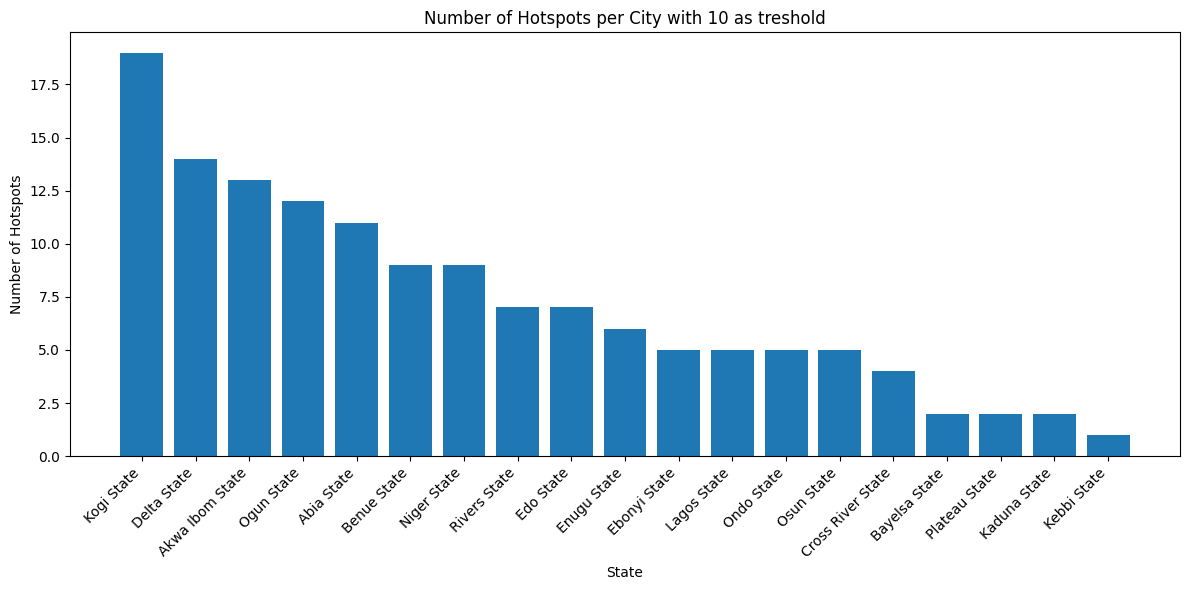

In [16]:


# Sort the DataFrame by 'number of hotspots' in descending order
hotspots_count_per_state_sorted = hotspots_count_per_state.sort_values(by='number of hotspots', ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(hotspots_count_per_state_sorted['City'], hotspots_count_per_state_sorted['number of hotspots'])
plt.xlabel('State')
plt.ylabel('Number of Hotspots')
plt.title('Number of Hotspots per City with 10 as treshold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

* **Assessing high-NDVI states in detail**

In [17]:
# prompt: i want to groupby state and extract akwa ibom
def extract_powerline_for_state(state_name):
    return data.groupby('City').get_group(state_name)

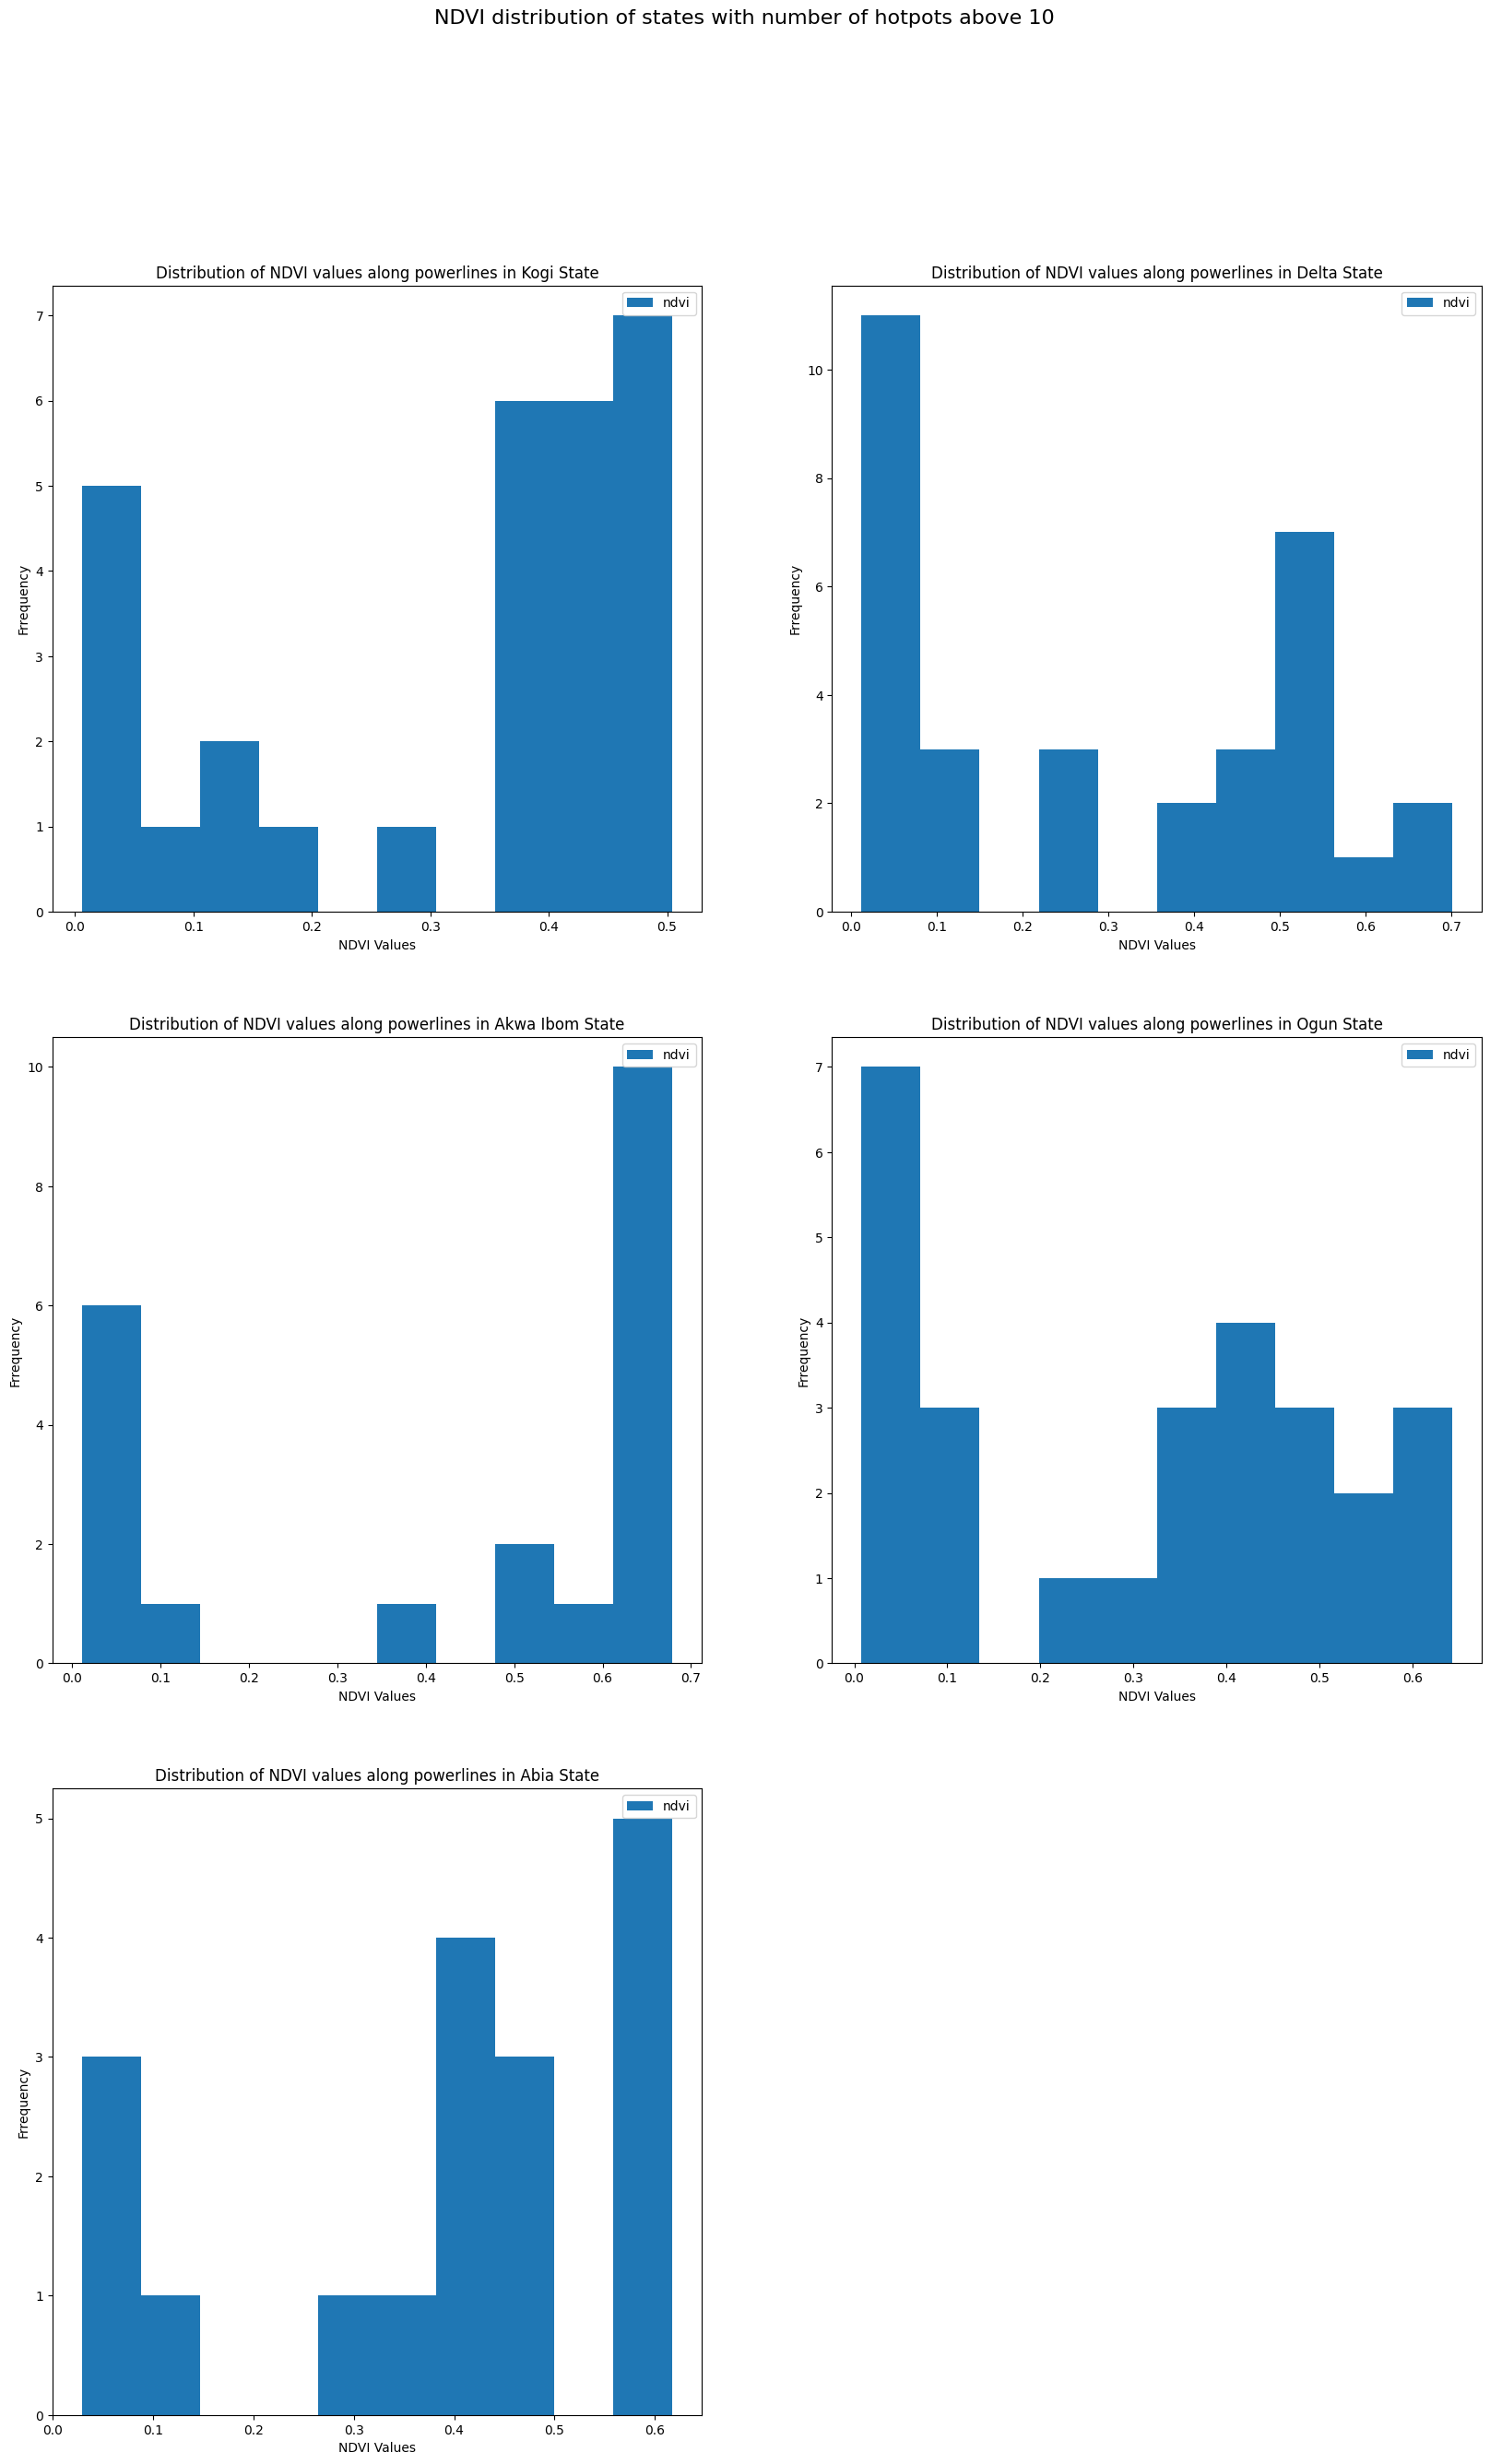

In [18]:
# Filter for Kogi State
kogi_data = extract_powerline_for_state('Kogi State')
delta_data = extract_powerline_for_state('Delta State')
akwa_ibom_data = extract_powerline_for_state('Akwa Ibom State')
ogun_data = extract_powerline_for_state('Ogun State')
abia_data = extract_powerline_for_state('Abia State')

# Create the histogram
fig, ax = plt.subplots(3, 2, figsize=(20, 30))  # Adjust figure size as needed

def plot_hist(data, row, column, name):
    data.plot(ax=ax[row, column], column='ndvi', kind='hist')
    ax[row,column].set_title(f'Distribution of NDVI values along powerlines in {name} State')
    ax[row,column].set_xlabel('NDVI Values')
    ax[row,column].set_ylabel('Frrequency')

plot_hist(kogi_data, 0, 0, 'Kogi')
plot_hist(delta_data, 0, 1, 'Delta')
plot_hist(akwa_ibom_data, 1, 0, 'Akwa Ibom')
plot_hist(ogun_data, 1, 1, 'Ogun')
plot_hist(abia_data, 2, 0, 'Abia')
ax[2, 1].axis('off')

plt.suptitle('NDVI distribution of states with number of hotpots above 10', fontsize=16)
plt.show()

In [19]:
def extract_boundary(state_name):
    print((admin_boundaries['City'] == state_name).sum(), "occurence of", state_name)
    return admin_boundaries[admin_boundaries['City'] == state_name]

kogi = extract_boundary("Kogi State")
delta = extract_boundary("Delta State")
akwa_ibom = extract_boundary("Akwa Ibom State")
ogun = extract_boundary("Ogun State")
abia = extract_boundary("Abia State")


1 occurence of Kogi State
1 occurence of Delta State
1 occurence of Akwa Ibom State
1 occurence of Ogun State
1 occurence of Abia State


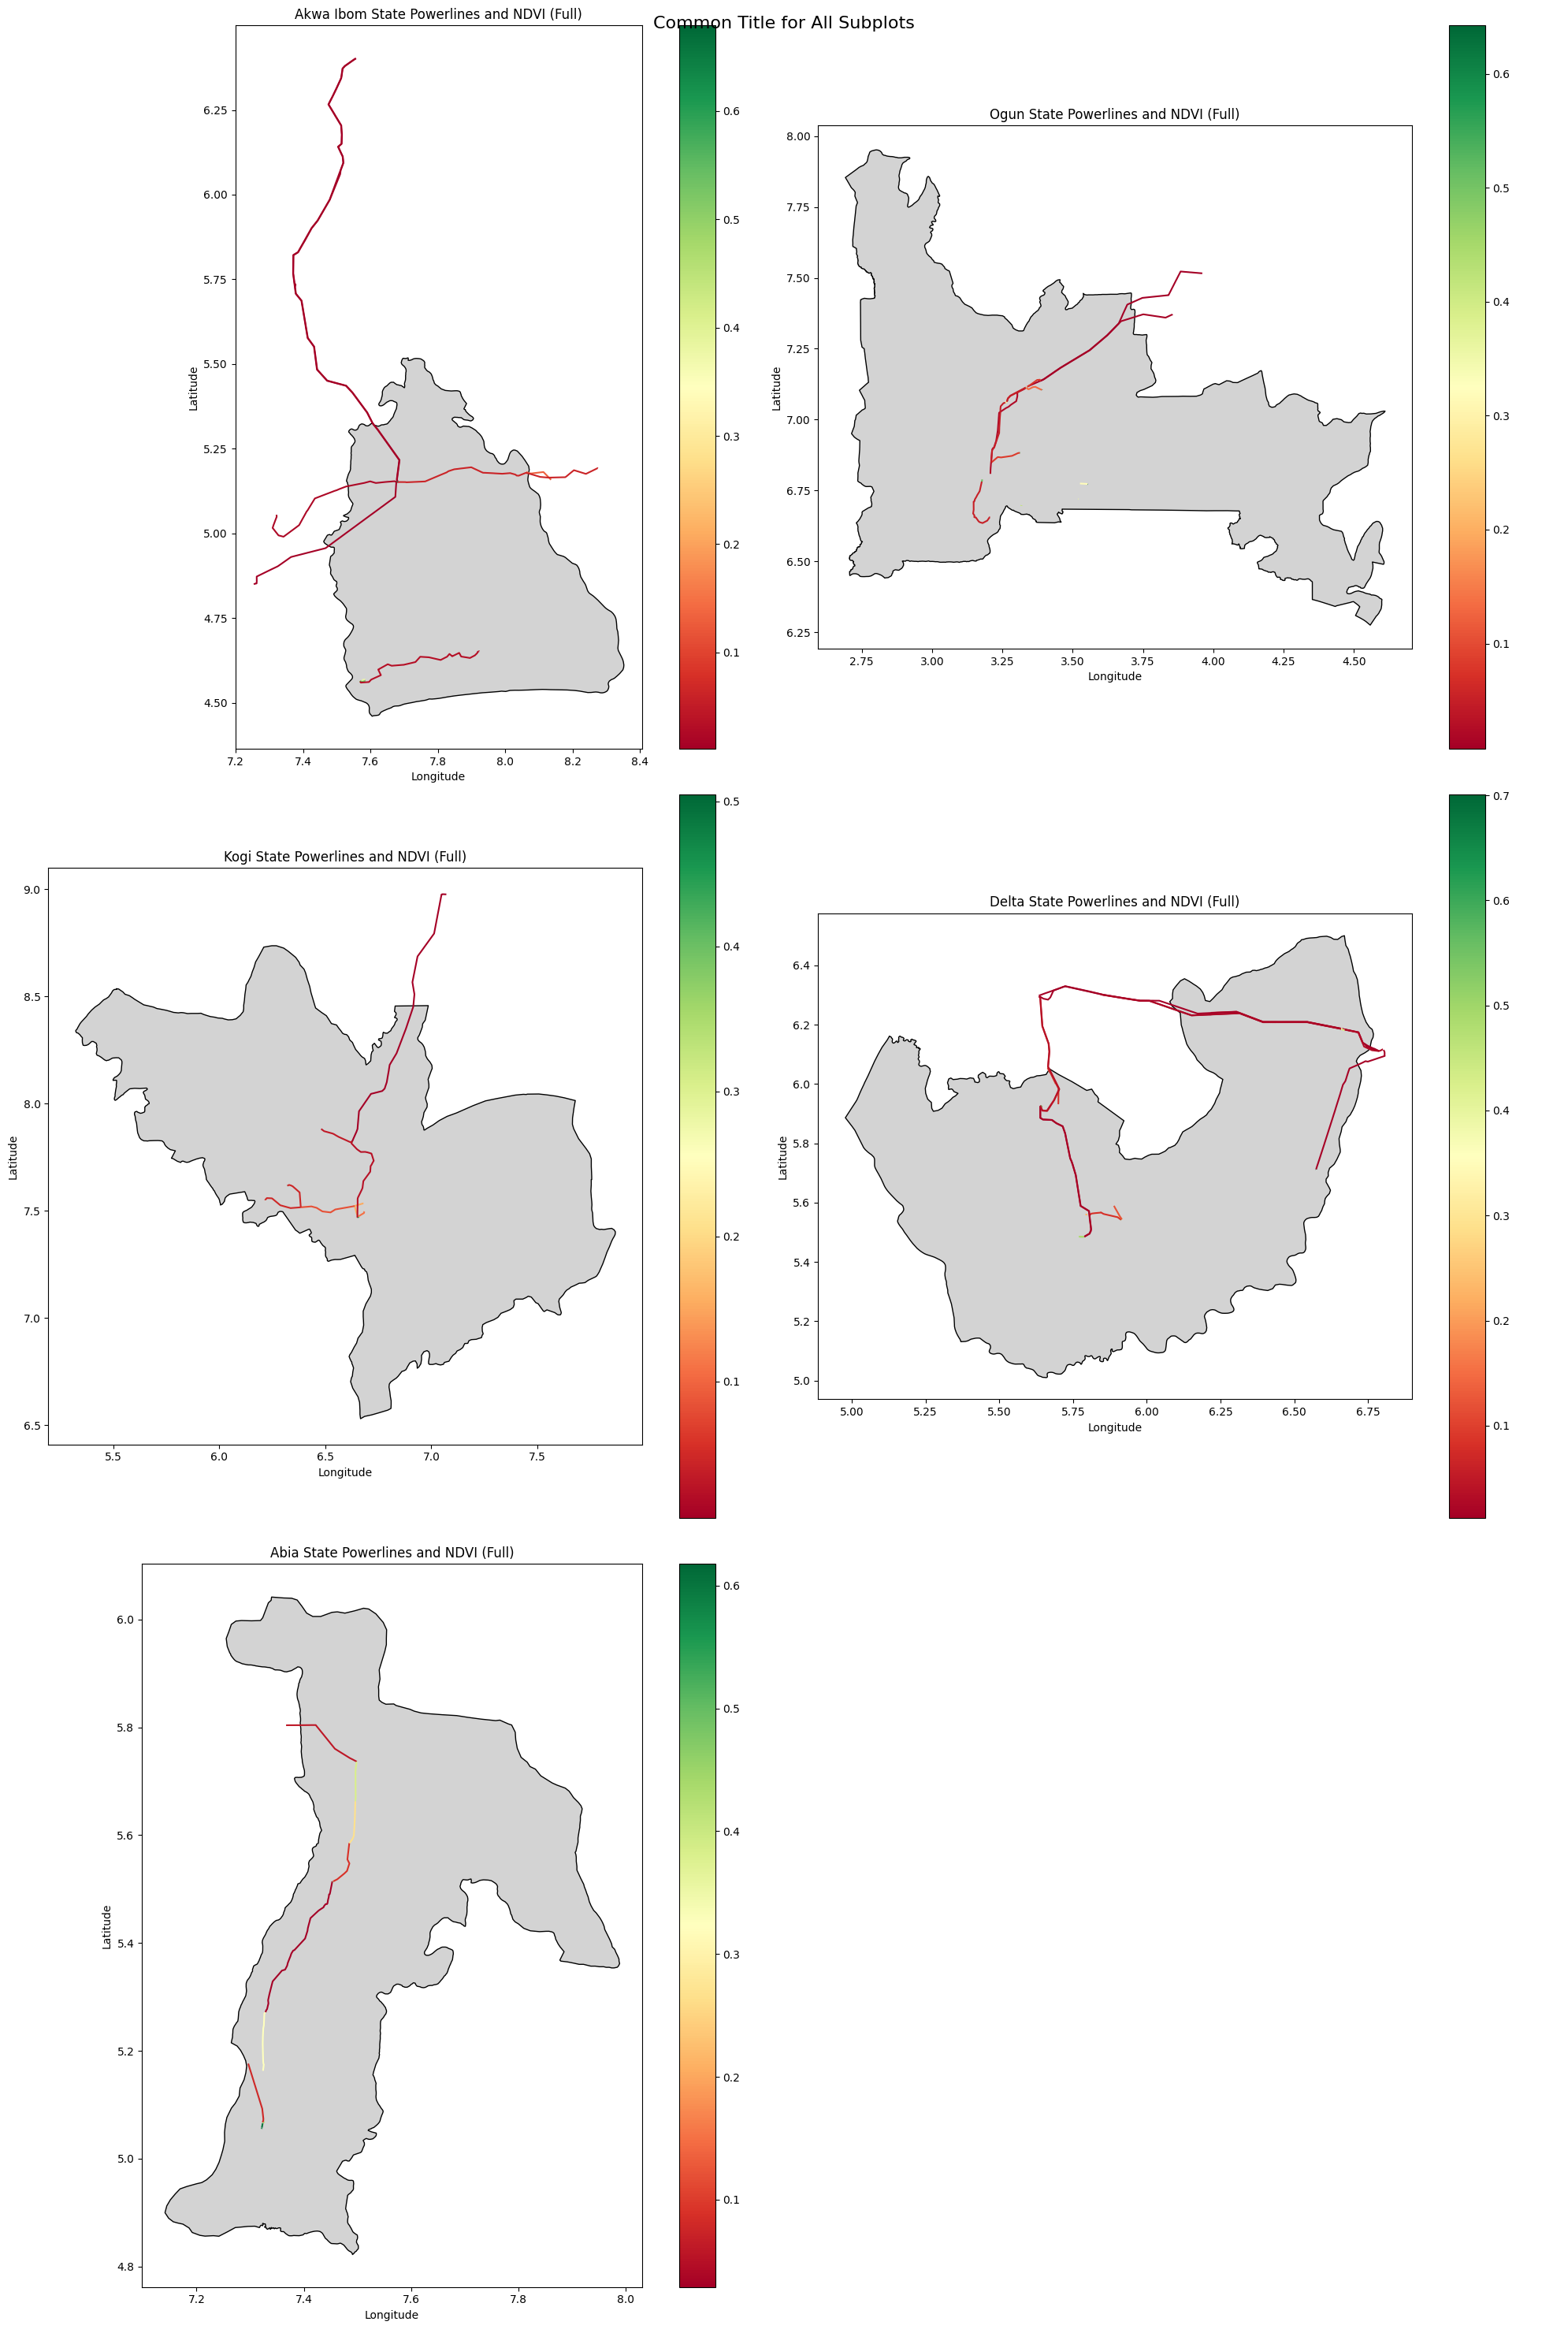

In [20]:
fig, ax = plt.subplots(3, 2, figsize=(20, 30))
def plot_boundary(row, column, boundary, powerline_data, state_name):
    boundary.plot(ax=ax[row, column], color='lightgray', edgecolor='black')
    powerline_data.plot(ax=ax[row, column], column='ndvi', legend=True, cmap='RdYlGn', markersize=20)
    ax[row, column].set_title(f'{state_name} Powerlines and NDVI (Full)')
    ax[row, column].set_xlabel('Longitude')
    ax[row, column].set_ylabel('Latitude')


plot_boundary(0, 0, akwa_ibom, akwa_ibom_data, 'Akwa Ibom State')
plot_boundary(0, 1, ogun, ogun_data, 'Ogun State')
plot_boundary(1, 0, kogi, kogi_data, 'Kogi State')
plot_boundary(1, 1, delta, delta_data, 'Delta State')
plot_boundary(2, 0, abia, abia_data, 'Abia State')
ax[2, 1].axis('off')
plt.suptitle('Common Title for All Subplots', fontsize=16)
plt.tight_layout()
plt.show()


In [21]:
# --- Zoom Functions ---
def plot_zoom(ax, xlim, ylim, boundary, powerline_data, state):
    boundary.plot(ax=ax, color='lightgray', edgecolor='black')
    powerline_data.plot(ax=ax, column='ndvi', legend=True, cmap='BrBG_r', markersize=20)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Get center coordinates for geocoding
    center_lon = (xlim[0] + xlim[1]) / 2
    center_lat = (ylim[0] + ylim[1]) / 2
   # Get location name using geocoding and find nearest known location
    location = geolocator.reverse((center_lat, center_lon), exactly_one=False)
        # Select the first location from the list (if available)
    location = location[0] if location else None
    if location:
        # nearest_location = min(location, key=lambda loc: geodesic((center_lat, center_lon), (loc.latitude, loc.longitude)).kilometers) #This line is causing the zoom function not to work well
        location_name = location.address.split(",")[0]  # Get the first part of the address (usually the nearest place)
    else:
        location_name = "Unknown Location"

    # Set title with location name
    ax.set_title(f'{state} Powerlines and NDVI (zoom - {location.raw["address"].get("city", "Unknown Location") if location else "Unknown Location but the area is centered latitude {center_lat} and longitude {center_lon}"})')

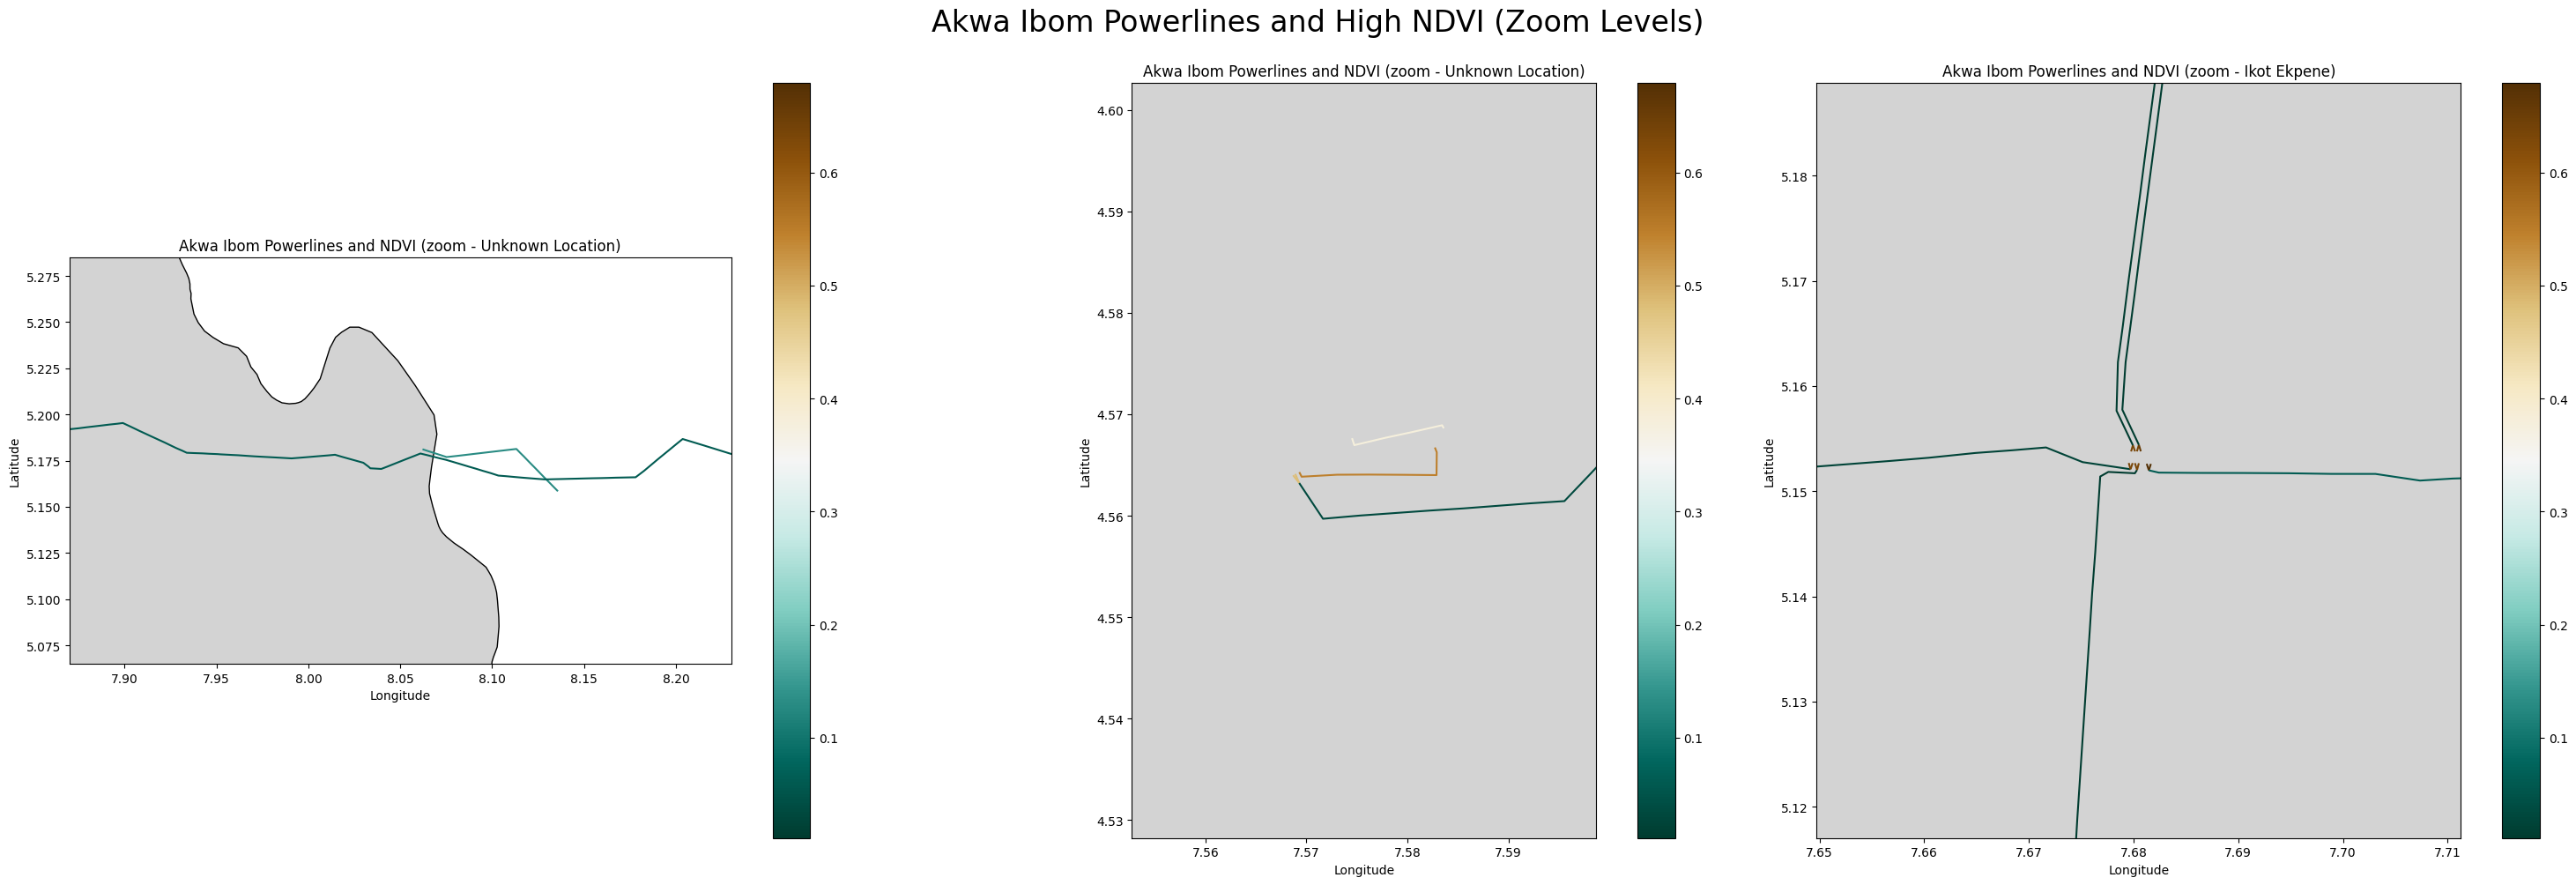

In [22]:
# Create a 1x3 grid of subplots (3 axes)
fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Adjust figure size as needed

x_range = akwa_ibom.total_bounds[2] - akwa_ibom.total_bounds[0]
y_range = akwa_ibom.total_bounds[3] - akwa_ibom.total_bounds[1]
longitude_factor = 0.3 / x_range
latitude_factor = 0.35 / y_range

# --- Zoom Levels ---
# Zoom 1 (Top Left)
# Adjust xlim and ylim to zoom out
# Calculate zoom factors
x_range = akwa_ibom.total_bounds[2] - akwa_ibom.total_bounds[0]
y_range = akwa_ibom.total_bounds[3] - akwa_ibom.total_bounds[1]
longitude_factor = 0.3 / x_range
latitude_factor = 0.35 / y_range

xlim_zoom1 = (7.9 - (longitude_factor * x_range / 10),
                  8.2 + (longitude_factor * x_range / 10))
ylim_zoom1 = (5.1 - (latitude_factor * y_range / 10),
                  5.25 + (latitude_factor * y_range / 10))
plot_zoom(axes[0], xlim_zoom1, ylim_zoom1, akwa_ibom, akwa_ibom_data, 'Akwa Ibom')


# Zoom 2 (Top Center)
xlim_zoom2 = (7.58272 - (longitude_factor * x_range / 10),
                  7.56868 + (longitude_factor * x_range / 10))
ylim_zoom2 = (4.56322 - (latitude_factor * y_range / 10),
                  4.56764 + (latitude_factor * y_range / 10))
plot_zoom(axes[1], xlim_zoom2, ylim_zoom2, akwa_ibom, akwa_ibom_data, 'Akwa Ibom')

# Zoom 3 (Top Right)
xlim_zoom3 = (7.67971 - (longitude_factor * x_range / 10),
                  7.68126 + (longitude_factor * x_range / 10))
ylim_zoom3 = (5.15203 - (latitude_factor * y_range / 10),
                 5.1538 + (latitude_factor * y_range / 10))
plot_zoom(axes[2], xlim_zoom3, ylim_zoom3, akwa_ibom, akwa_ibom_data,'Akwa Ibom')


plt.suptitle('Akwa Ibom Powerlines and High NDVI (Zoom Levels)', y = 1, fontsize=24)
plt.tight_layout()
plt.show()

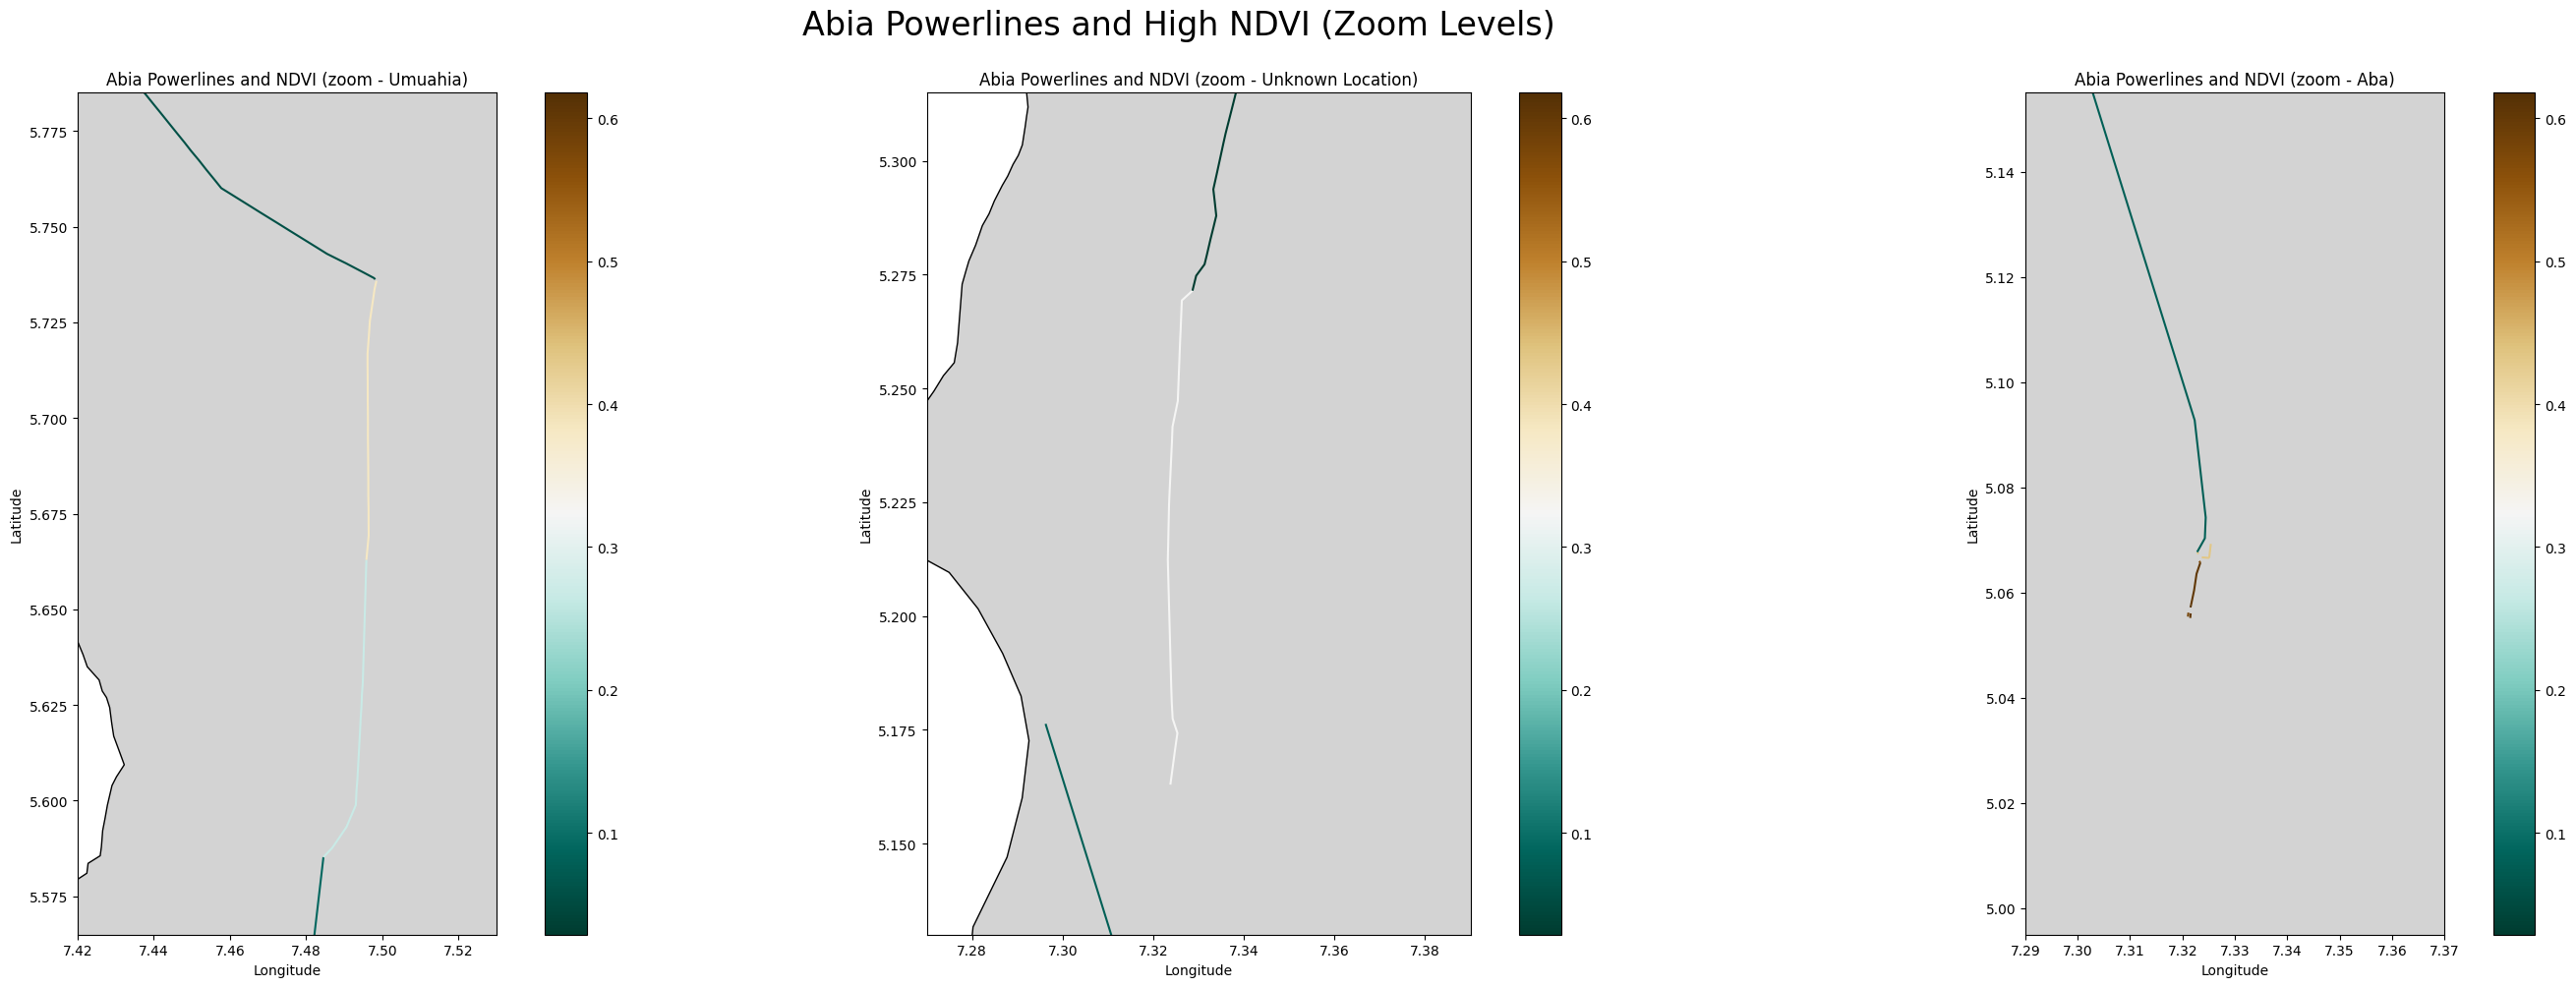

In [23]:
# Create a 1x3 grid of subplots (3 axes)
fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Adjust figure size as needed

# --- Zoom Levels ---
# Zoom 1
# Adjust xlim and ylim to zoom out
# Calculate zoom factors
x_range = abia.total_bounds[2] - abia.total_bounds[0]
y_range = abia.total_bounds[3] - abia.total_bounds[1]
longitude_factor = 0.3 / x_range
latitude_factor = 0.35 / y_range

xlim_zoom1 = (7.450 - (longitude_factor * x_range / 10),
                  7.500 + (longitude_factor * x_range / 10))
ylim_zoom1 = (5.600 - (latitude_factor * y_range / 10),
                  5.750 + (latitude_factor * y_range / 10))
plot_zoom(axes[0], xlim_zoom1, ylim_zoom1,  abia, abia_data, 'Abia')


# Zoom 2 (Top Center)
xlim_zoom2 = (7.300 - (longitude_factor * x_range / 10),
                  7.360 + (longitude_factor * x_range / 10))
ylim_zoom2 = (5.165 - (latitude_factor * y_range / 10),
                  5.280 + (latitude_factor * y_range / 10))
plot_zoom(axes[1], xlim_zoom2, ylim_zoom2,  abia, abia_data, 'Abia')

# Zoom 3 (Top Right)
xlim_zoom3 = (7.320 - (longitude_factor * x_range / 10),
                  7.340 + (longitude_factor * x_range / 10))
ylim_zoom3 = (5.030 - (latitude_factor * y_range / 10),
                 5.120 + (latitude_factor * y_range / 10))
plot_zoom(axes[2], xlim_zoom3, ylim_zoom3,  abia, abia_data, 'Abia')


plt.suptitle('Abia Powerlines and High NDVI (Zoom Levels)', y = 1, fontsize=24)
plt.tight_layout()
plt.show()

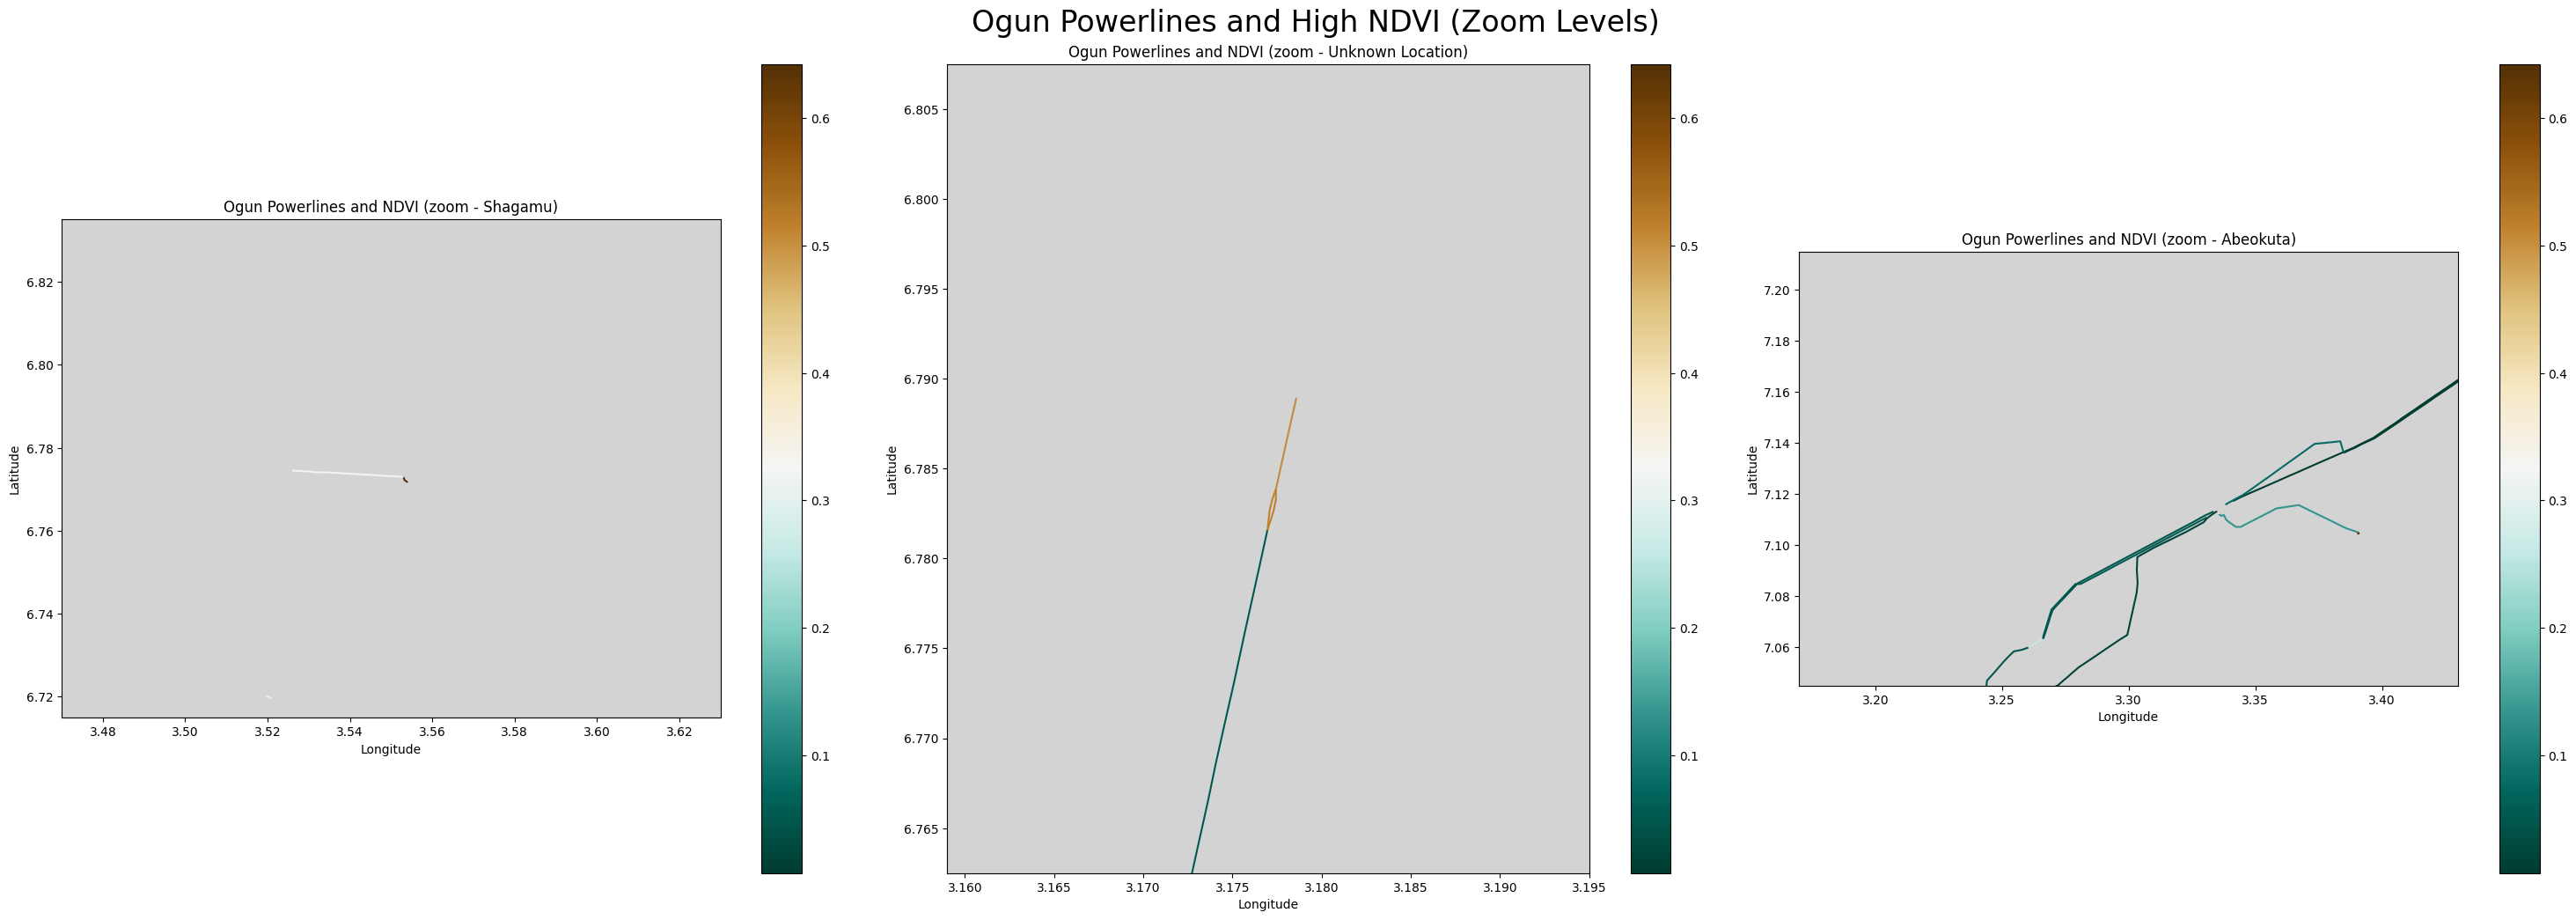

In [24]:
# Create a 1x3 grid of subplots (3 axes)
fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Adjust figure size as needed

# --- Zoom Levels ---
# Zoom 1
# Adjust xlim and ylim to zoom out
# Calculate zoom factors
x_range = ogun.total_bounds[2] - ogun.total_bounds[0]
y_range = ogun.total_bounds[3] - ogun.total_bounds[1]
longitude_factor = 0.3 / x_range
latitude_factor = 0.35 / y_range

xlim_zoom1 = (3.5 - (longitude_factor * x_range / 10),
                  3.6 + (longitude_factor * x_range / 10))
ylim_zoom1 = (6.75 - (latitude_factor * y_range / 10),
                  6.8 + (latitude_factor * y_range / 10))
plot_zoom(axes[0], xlim_zoom1, ylim_zoom1,  ogun, ogun_data, 'Ogun')


# Zoom 2 (Top Center)
xlim_zoom2 = (3.174 - (longitude_factor * x_range / 20),
                  3.180 + (longitude_factor * x_range / 20))
ylim_zoom2 = (6.780 - (latitude_factor * y_range / 20),
                  6.790 + (latitude_factor * y_range / 20))
plot_zoom(axes[1], xlim_zoom2, ylim_zoom2,  ogun, ogun_data, 'Ogun')

# Zoom 3 (Top Right)
xlim_zoom3 = (3.2 - (longitude_factor * x_range / 10),
                  3.4 + (longitude_factor * x_range / 10))
ylim_zoom3 = (7.08 - (latitude_factor * y_range / 10),
                 7.18 + (latitude_factor * y_range / 10))
plot_zoom(axes[2], xlim_zoom3, ylim_zoom3,  ogun, ogun_data, 'Ogun')


plt.suptitle('Ogun Powerlines and High NDVI (Zoom Levels)', y = 1, fontsize=24)
plt.tight_layout()
plt.show()

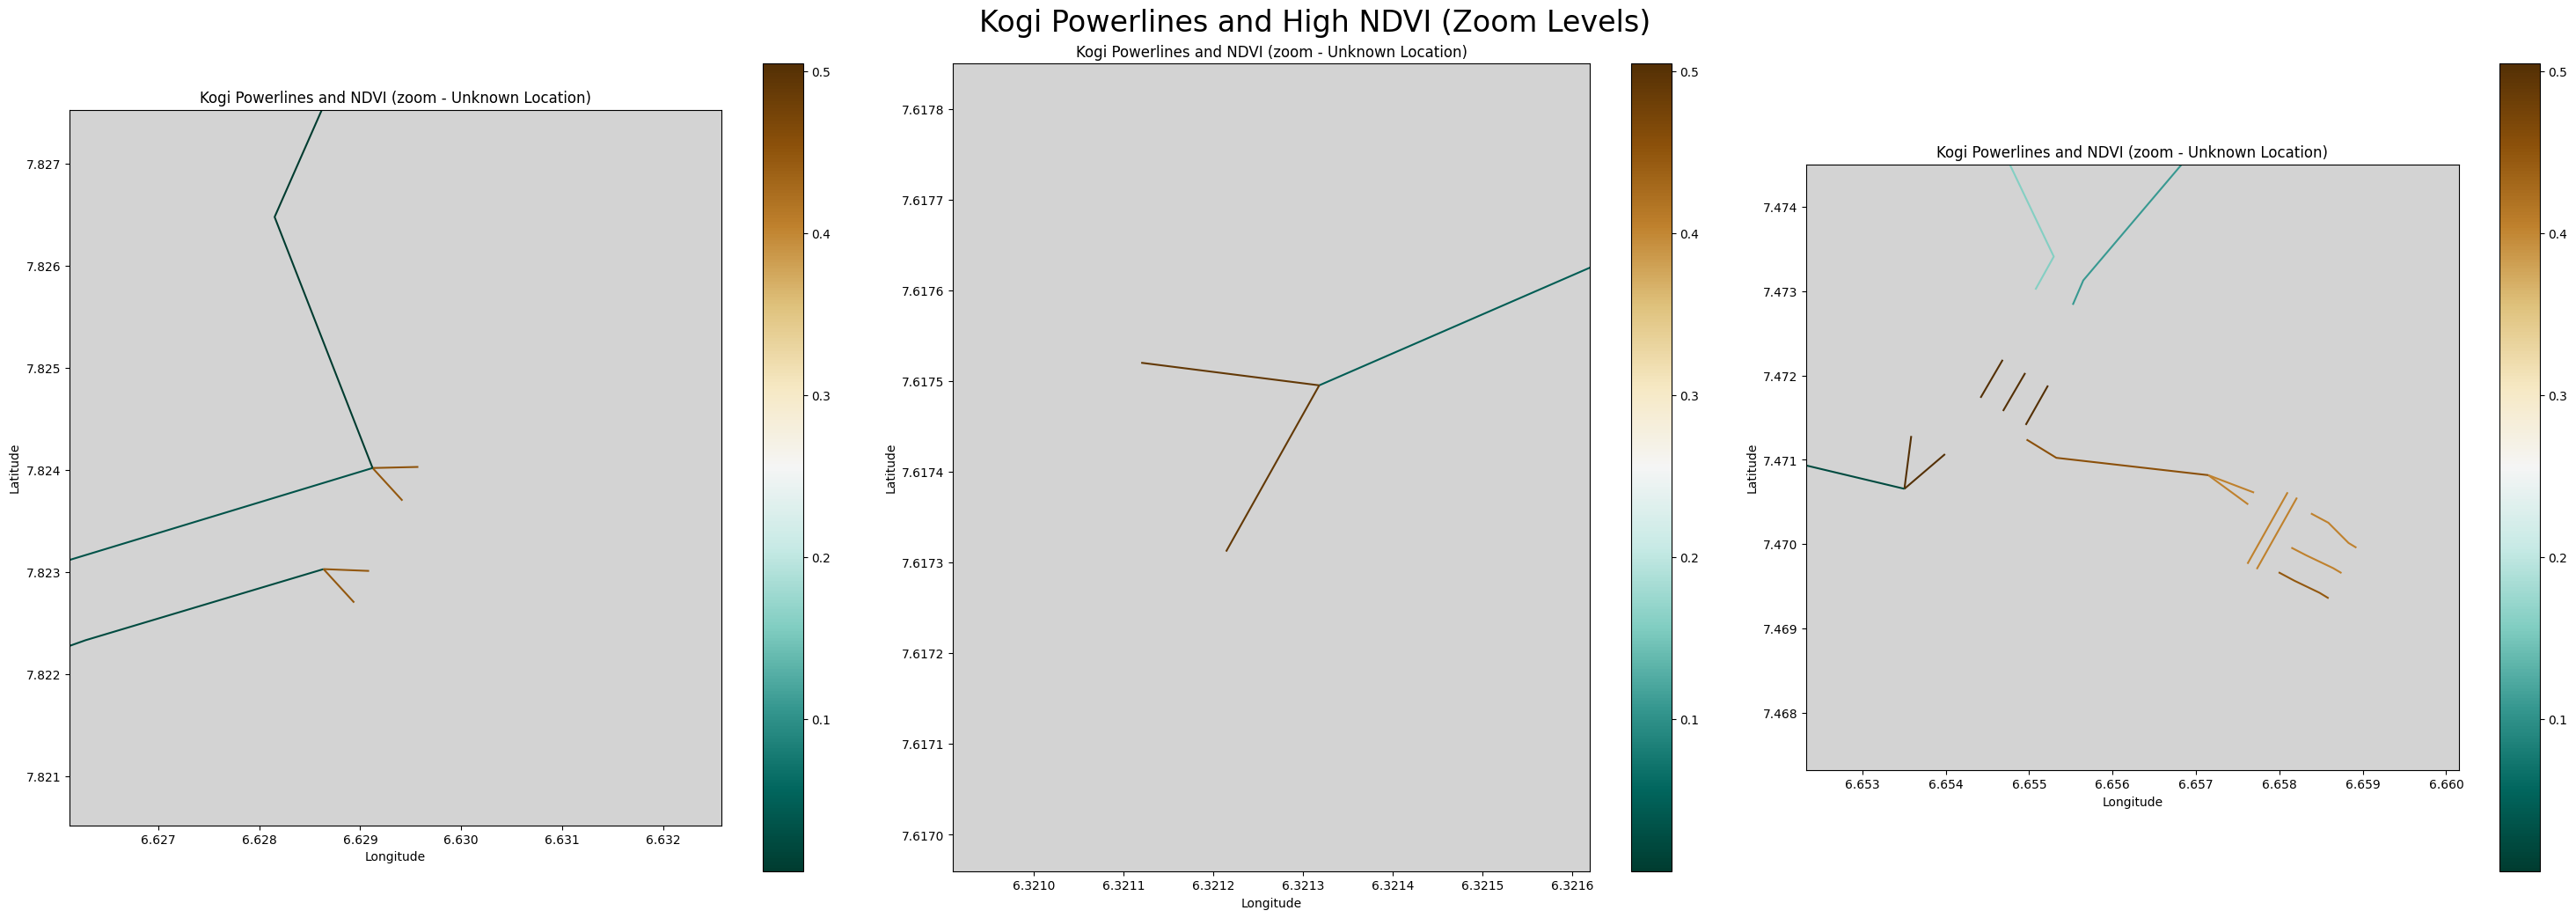

In [25]:

# Create a 1x3 grid of subplots (3 axes)
fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Adjust figure size as needed

# --- Zoom Levels ---
# Zoom 1
# Adjust xlim and ylim to zoom out
# Calculate zoom factors
x_range = kogi.total_bounds[2] - kogi.total_bounds[0]
y_range = kogi.total_bounds[3] - kogi.total_bounds[1]
longitude_factor = 0.3 / x_range
latitude_factor = 0.35 / y_range

xlim_zoom1 = (6.62912 - (longitude_factor * x_range / 100),
                   6.62958 + (longitude_factor * x_range / 100))
ylim_zoom1 = (7.82402 - (latitude_factor * y_range / 100),
                  7.82403 + (latitude_factor * y_range / 100))
plot_zoom(axes[0], xlim_zoom1, ylim_zoom1,  kogi, kogi_data, 'Kogi')


# Zoom 2 (Top Center)
xlim_zoom2 = (6.32121 - (longitude_factor * x_range / 1000),
                  6.32132 + (longitude_factor * x_range / 1000))
ylim_zoom2 = (7.61731- (latitude_factor * y_range / 1000),
                  7.6175 + (latitude_factor * y_range / 1000))
plot_zoom(axes[1], xlim_zoom2, ylim_zoom2,  kogi, kogi_data, 'Kogi')

# Zoom 3 (Top Right)
xlim_zoom3 = (6.65533 - (longitude_factor * x_range / 100),
                  6.65715 + (longitude_factor * x_range / 100))
ylim_zoom3 = (7.47082 - (latitude_factor * y_range / 100),
                 7.4710 + (latitude_factor * y_range / 100))
plot_zoom(axes[2], xlim_zoom3, ylim_zoom3,  kogi, kogi_data, 'Kogi')


plt.suptitle('Kogi Powerlines and High NDVI (Zoom Levels)', y = 1, fontsize=24)
plt.tight_layout()
plt.show()

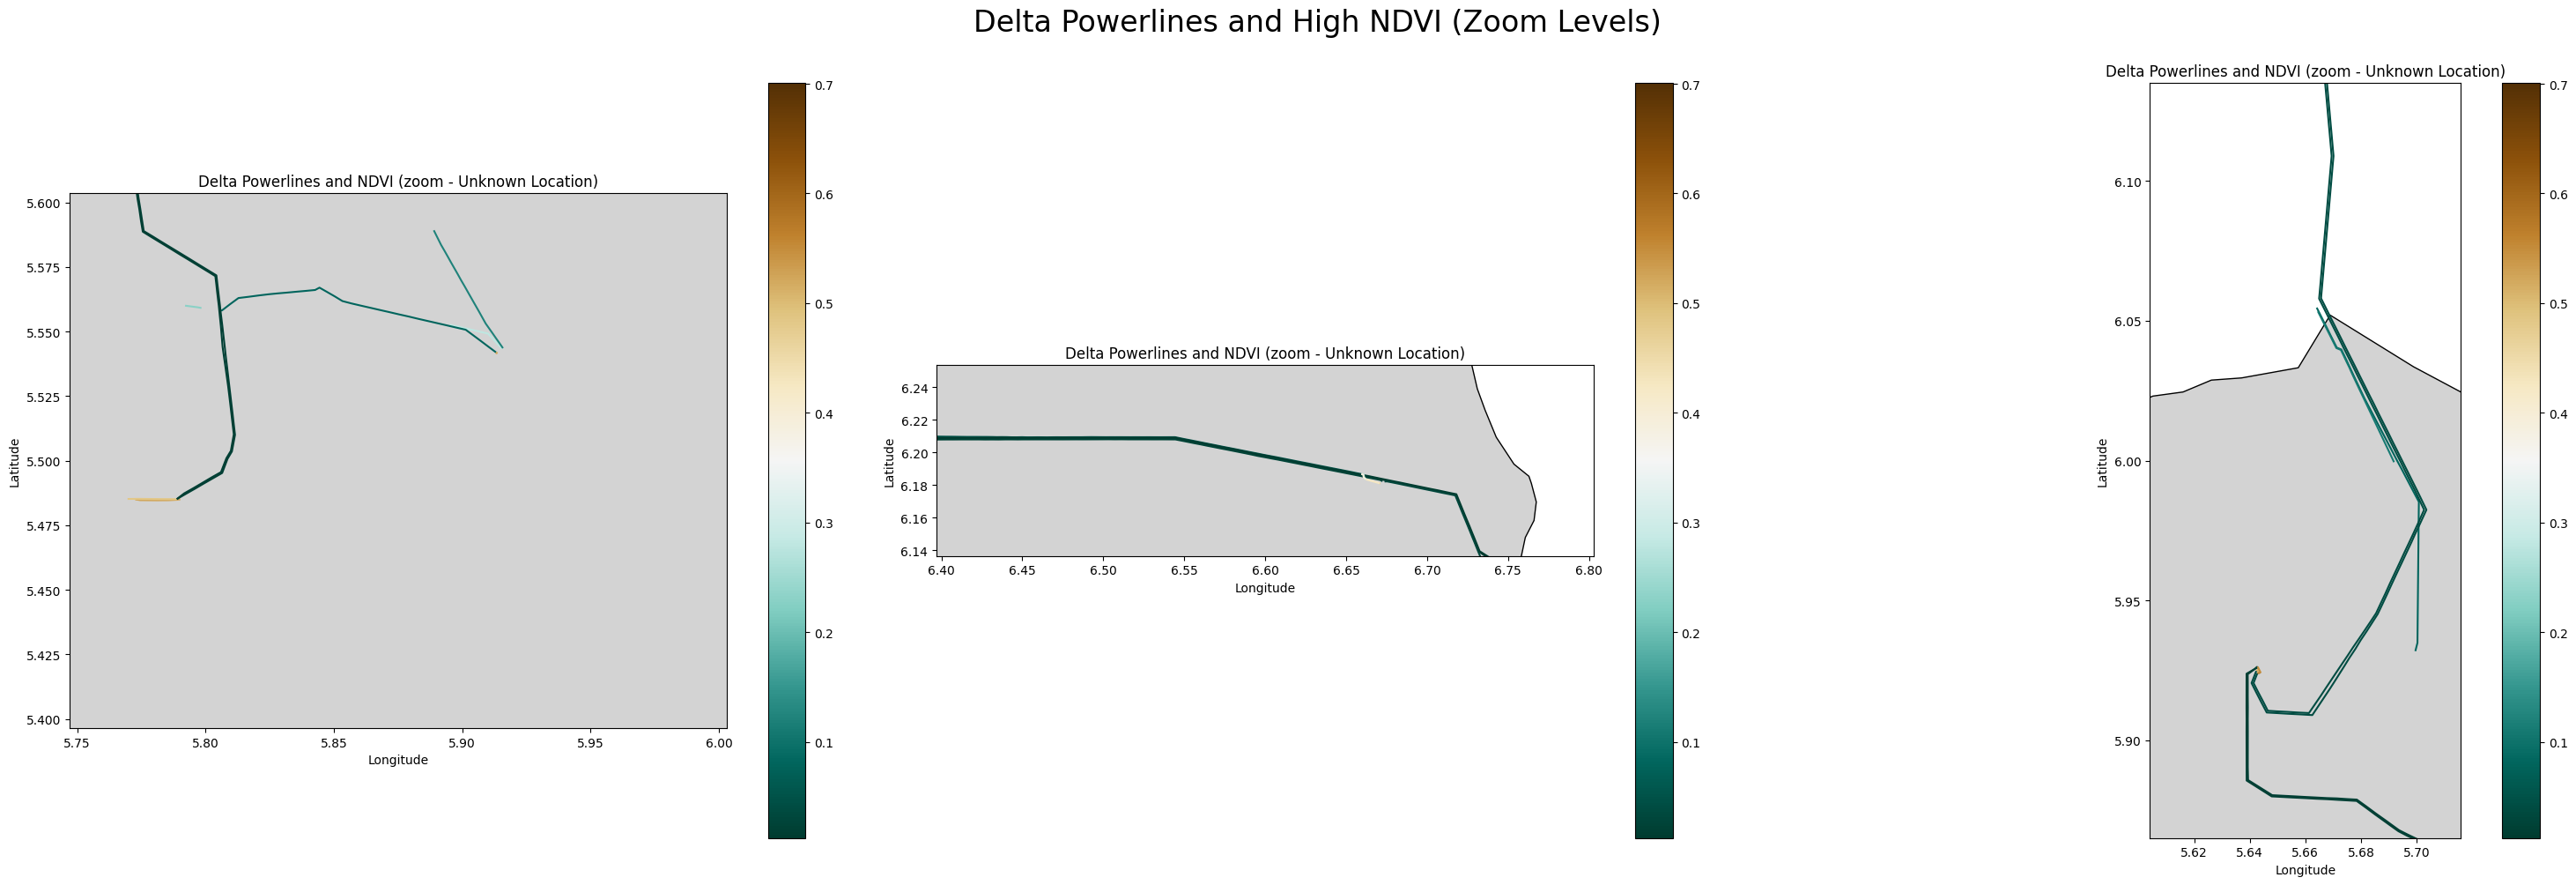

In [26]:

# Create a 1x3 grid of subplots (3 axes)
fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # Adjust figure size as needed

# --- Zoom Levels ---
# Zoom 1
# Adjust xlim and ylim to zoom out
# Calculate zoom factors
x_range = delta.total_bounds[2] - delta.total_bounds[0]
y_range = delta.total_bounds[3] - delta.total_bounds[1]
longitude_factor = 0.3 / x_range
latitude_factor = 0.35 / y_range

xlim_zoom1 = (5.75 - (longitude_factor * x_range / 100),
                   6.00 + (longitude_factor * x_range / 100))
ylim_zoom1 = (5.4 - (latitude_factor * y_range / 100),
                  5.6 + (latitude_factor * y_range / 100))
plot_zoom(axes[0], xlim_zoom1, ylim_zoom1,  delta, delta_data, 'Delta')


# Zoom 2 (Top Center)
xlim_zoom2 = (6.4 - (longitude_factor * x_range / 100),
                  6.8 + (longitude_factor * x_range / 100))
ylim_zoom2 = (6.14- (latitude_factor * y_range / 100),
                 6.25 + (latitude_factor * y_range / 100))
plot_zoom(axes[1], xlim_zoom2, ylim_zoom2,  delta, delta_data, 'Delta')

# Zoom 3 (Top Right)
xlim_zoom3 = (5.61 - (longitude_factor * x_range / 50),
                 5.71 + (longitude_factor * x_range / 50))
ylim_zoom3 = (5.9 - (latitude_factor * y_range / 10),
                 6.1 + (latitude_factor * y_range / 10))
plot_zoom(axes[2], xlim_zoom3, ylim_zoom3,  delta, delta_data, 'Delta')


plt.suptitle('Delta Powerlines and High NDVI (Zoom Levels)', y = 1, fontsize=24)
plt.tight_layout()
plt.show()

###### How do the average NDVI values for states in Nigeria compare to national or regional averages?

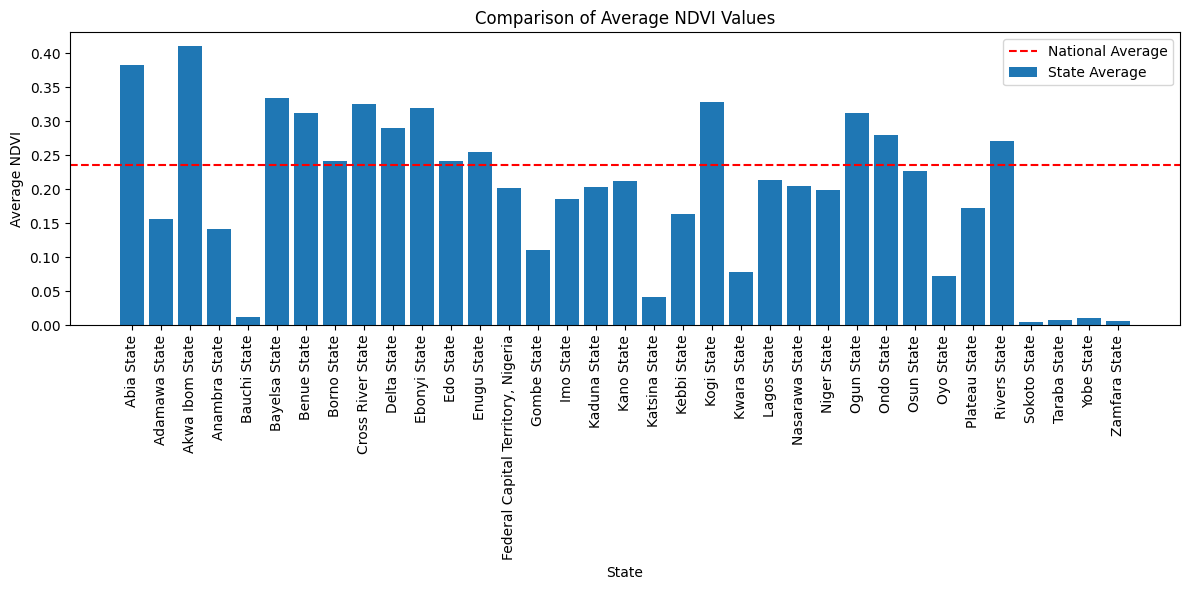

In [28]:
national_average = data['ndvi'].mean()
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(average_ndvi.index, average_ndvi.values, label='State Average')
plt.axhline(y=national_average, color='red', linestyle='--', label='National Average')

# Customize plot
plt.title('Comparison of Average NDVI Values')
plt.xlabel('State')
plt.ylabel('Average NDVI')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend()
plt.tight_layout()
plt.show()

###### Are there any geographic patterns or clusters in the distribution of high-NDVI states

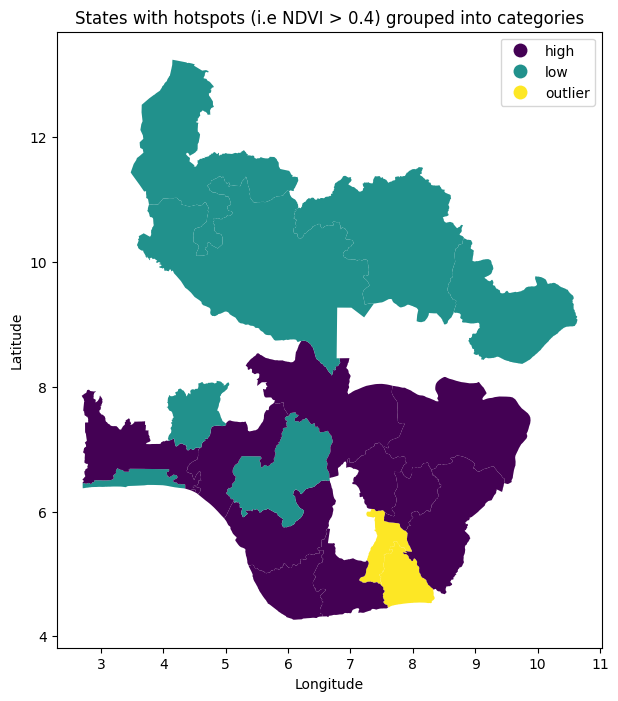

In [70]:
# prompt: please give the choropleth map of the category

import matplotlib.pyplot as plt

# Assuming 'merged_data' is your GeoDataFrame with 'geometry', 'City', and 'ndvi_category' columns.

# Create the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_data.plot(column='ndvi_category', cmap='viridis', legend=True, ax=ax,
                 categorical=True, legend_kwds={'loc': 'upper right'})  # Use categorical=True for discrete categories


ax.set_title('States with hotspots (i.e NDVI > 0.4) grouped into categories')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

High-NDVI Cluster: States grouped together in this cluster generally have higher average NDVI values along their powerlines. This suggests a potentially higher risk of vegetation encroachment in these areas. These states might require more frequent monitoring and vegetation management to mitigate the risk of power outages.

---


Low-NDVI Cluster: States in this cluster exhibit lower average NDVI values, indicating a relatively lower risk of vegetation encroachment. While these areas might still require monitoring, the frequency and intensity of vegetation management could be lower compared to the high-risk cluster.

---


Outliers: DBSCAN can identify data points that don't belong to any cluster. These outliers could represent states with unique characteristics that might require specific attention. These states might have highly variable NDVI values or powerline configurations that don't fit the general patterns of the other clusters.